# Import libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import json
import yaml



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
from alinemol.preprocessing import standardize_smiles, drop_duplicates
from alinemol.utils.split_utils import get_scaffold, convert_to_default_feats_if_smiles, EmpiricalKernelMapTransformer
from alinemol.splitters.splits import MolecularLogPSplit

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
Draw.SetComicMode(IPythonConsole.drawOptions)

import datamol as dm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


In [3]:
#light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
#dark_color = "black"


#matplotlib.use("pgf")


matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 14,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "legend.loc": "upper right",
    }
)

sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)

# Standardize the dataset

In [ ]:
dataset_name = "AMES"
mol_file = os.path.join(DATASET_PATH, "TDC", dataset_name, f"{dataset_name}_simplified.csv")
mol_df = pd.read_csv(mol_file)
print(mol_df.shape)

In [ ]:
mol_df

In [ ]:
mol_df = standardize_smiles(mol_df)
print(mol_df.shape)

In [ ]:
mol_df = drop_duplicates(mol_df)
print(mol_df.shape)

In [ ]:
mol_df

In [ ]:
df = mol_df[["canonical_smiles", "label"]]
df.columns = ["smiles", "label"]

df.to_csv(os.path.join(DATASET_PATH, "TDC", dataset_name, f"{dataset_name}_standardize.csv"), index=False)

In [ ]:
mol_df[mol_df['canonical_smiles'].duplicated()]

In [ ]:
X = np.array(mol_df["smiles"])
y = np.array(mol_df["label"])

In [ ]:
scaf = [get_scaffold(smi) for smi in X]

In [ ]:
## chosse 6 random structure and corresponding scaffold
np.random.seed(7)
idx = np.random.choice(len(X), 6)
mols = [Chem.MolFromSmiles(X[i]) for i in idx]
scafs = [Chem.MolFromSmiles(scaf[i]) for i in idx]

## draw the molecules and their scaffolds
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img

In [ ]:
# Draw scaffold
img_scaf = Draw.MolsToGridImage(scafs, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img_scaf

In [ ]:
dataset_category="MoleculeNet"
dataset_names="HIV"
dataset = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_simplified" + ".csv"))

In [ ]:
dataset

In [ ]:
dataset['smiles'].duplicated().sum()

In [ ]:
new_df = standardize_smiles(dataset)

In [ ]:
new_df

In [ ]:
new_df['canonical_smiles'].isna().sum()

In [ ]:
new_df = new_df.dropna(subset=['canonical_smiles'])
new_df = new_df[["canonical_smiles", "label"]]
new_df.columns = ["smiles", "label"]

In [ ]:
new_df.to_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_processed" + ".csv"), index=False)

In [ ]:
new_df[new_df['smiles'].duplicated()]

In [ ]:
dff = new_df[new_df.groupby('smiles').label.transform('nunique') == 1]

In [ ]:
dff=dff.drop_duplicates(subset=['smiles'], keep='first')

In [ ]:
dff.reset_index(drop=True, inplace=True)

In [ ]:
dff.label.value_counts()

In [ ]:
new_df.groupby('smiles').label.nunique()>1

In [ ]:
new_df.groupby('smiles').label.transform('nunique')

In [ ]:
x  = ['CC', 'CC', 'CC', 'CCC', 'CCC', 'CCCC', 'CCCCC', 'CCCCC']
label= [1, 1, 0, 1, 1, 1, 1, 0]
df = pd.DataFrame({'smiles': x, 'label': label})
df = standardize_smiles(df)

In [ ]:
df = df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [ ]:
drop_duplicates(df)['label'].nunique()

In [ ]:
mol_df = mol_df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [ ]:
import splito
from splito import *

In [ ]:
def splits_scaffold(test_dataset_dili, make_generic):
    smiles = test_dataset_dili["smiles"].values
    splitter = ScaffoldSplit(smiles, n_splits=5, make_generic=make_generic, test_size=None)
    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_scfs = set([get_scaffold(smiles[i], make_generic=make_generic) for i in train_ind])
        print(len(train_scfs))
        test_scfs = [get_scaffold(smiles[i], make_generic=make_generic) for i in test_ind]
        print(len(test_scfs))
        print(len(set(test_scfs)))
        print(test_scfs[0])
        assert not any(test_scf in train_scfs for test_scf in test_scfs)

In [ ]:
splits_scaffold(mol_df, make_generic=False)

In [ ]:
import datamol as dm

In [ ]:
def splits_molecular_weight(test_dataset_dili, generalize_to_larger):
    smiles = test_dataset_dili["smiles"].values
    splitter = MolecularWeightSplit(generalize_to_larger=generalize_to_larger, n_splits=2, test_size=0.1)

    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > len(test_ind)
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_mws = [dm.descriptors.mw(dm.to_mol(smi)) for smi in smiles[train_ind]]
        if generalize_to_larger:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) >= max(train_mws) for smi in smiles[test_ind]
            )
        else:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) <= min(train_mws) for smi in smiles[test_ind]
            )

In [ ]:
from splito import MaxDissimilaritySplit

In [ ]:
def test_splits_max_dissimilar_default_feats(test_dataset_smiles):
    splitter = MaxDissimilaritySplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0

In [ ]:
mol_df

In [ ]:
smiles = mol_df["smiles"].values

In [ ]:
test_splits_max_dissimilar_default_feats(smiles)

In [ ]:
from splito import PerimeterSplit


def test_splits_perimeter(test_dataset_smiles):
    splitter = PerimeterSplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        assert splitter._metric == "jaccard"

In [ ]:
splitter = PerimeterSplit(n_splits=2)

In [ ]:
splitter

In [ ]:
splitter = PerimeterSplit(n_splits=2)

for train_ind, test_ind in splitter.split(smiles):
    assert len(train_ind) + len(test_ind) == len(smiles)
    assert len(set(train_ind).intersection(set(test_ind))) == 0
    assert len(train_ind) > 0 and len(test_ind) > 0
    assert splitter._metric == "jaccard"

In [ ]:
splits_molecular_weight(mol_df, generalize_to_larger=True)

In [ ]:
## aplly all the splitter that are available in splito on the moldf dataset and create train and test index
splitter = splito.MolecularWeightSplit(test_size=0.2, generalize_to_larger=True)
train_idx, test_idx = next(splitter.split(X=mol_df.smiles.tolist()))
assert train_idx.shape[0] > test_idx.shape[0]

In [ ]:
mol_df.loc[train_idx, "MolecularWeightSplit"] = "train"
mol_df.loc[test_idx, "MolecularWeightSplit"] = "test"

In [ ]:
import datamol as dm

In [ ]:
mol_df["mw"] = mol_df.smiles.apply(lambda smi: dm.descriptors.mw(dm.to_mol(smi)))

In [ ]:
mol_df.groupby(by="MolecularWeightSplit")["mw"].hist(legend=True)

In [ ]:
mol_df =mol_df[-mol_df.duplicated()]

In [ ]:
from alinemol.utils.split_utils import get_scaffold
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold"] = get_scaffold(mol_df.loc[idx, "smiles"])

In [ ]:
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold_generic"] = get_scaffold(mol_df.loc[idx, "smiles"], make_generic=True)

In [ ]:
mol_df['scaffold_generic'].nunique()

In [ ]:
dataset_category="MoleculeNet"
dataset_names="HIV"
split_type="scaffold"
filename="external_test_balanced.csv"
train_filename="train_balanced.csv"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

In [ ]:
external_test = pd.read_csv(os.path.join (SPLIT_PATH, split_type, filename))
train = pd.read_csv(os.path.join (SPLIT_PATH, split_type, train_filename))
df = pd.concat([external_test, train])

In [ ]:
#df= pd.read_csv("datasets/TDC/CYP3A4/CYP3A4_simplified.csv")

In [ ]:
train_scaf = [get_scaffold(smi) for smi in train["smiles"]]
external_test_scaf = [get_scaffold(smi) for smi in external_test["smiles"]]
df_scaf = [get_scaffold(smi) for smi in df["smiles"]]


In [ ]:
pd.Series(df_scaf).value_counts(sort=False).plot(kind='bar')

In [ ]:
fis, ax=plt.subplots(1, 3, figsize=(15, 5))
pd.Series(train_scaf).value_counts(sort=False).plot(kind='bar', ax=ax[0])

In [ ]:
df_scaf_uni = list(set(df_scaf))

In [ ]:
#plot hist of df_scaf
from collections import Counter
#a=Counter(df_scaf)
#print(a)
import matplotlib.pyplot as plt
plt.hist(np.array(df_scaf), bins=10)
#plt.show()

In [ ]:
print(len(df_scaf_uni))
print(df.shape)
print(len(df_scaf_uni)/df.shape[0])

In [ ]:
train_scaf_uni = list(set(train_scaf))
external_test_scaf_uni = list(set(external_test_scaf))

print(len(train_scaf_uni))
print(len(train_scaf_uni)/train.shape[0])
print(len(external_test_scaf_uni))
print(len(external_test_scaf_uni)/external_test.shape[0])

print(set(train_scaf_uni).intersection(set(external_test_scaf_uni)))

# Dataset (train/test) charactersitics

## Train and Test Active percentage

In [ ]:
# Find the size and activity ratio in simplified and standardize dataset for all dataset
dataset_names = ["CYP1A2", "CYP2C9", "CYP2C19", "CYP2D6", "CYP3A4", "HIV", "AMES", "HERG"]
for dataset in dataset_names:
    df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_simplified.csv"))
    df_std = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
    print(f"Dataset: {dataset}")
    print(f"Size of simplified dataset: {df.shape[0]}")
    print(f"Size of standardize dataset: {df_std.shape[0]}")
    print(f"Activity ratio in simplified dataset: {df['label'].mean()}")
    print(f"Activity ratio in standardize dataset: {df_std['label'].mean()}")

In [ ]:
dataset_category="TDC"
dataset_names="CYP1A2"
split_type="scaffold"

active_train= []
active_test = []
dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

with open(os.path.join(dataset_folder, "config.json"), "r") as f:
    data_config = json.load(f)

for i in range(10):
    active_train.append(data_config[f"train_actives_percentage_{i}"])
    active_test.append(data_config[f"test_actives_percentage_{i}"])

#create df for sns plot
df = pd.DataFrame()
df['split'] = ['train'] *10 + ['test'] *10
df['active'] = active_train + active_test
df['id'] = list(range(10)) * 2

#plot active train vs active test as a bar plot in the same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='id', y='active', data=df, ax=ax, hue='split')
ax.set_ylabel("Active percentage", fontsize=16)
ax.set_xlabel("Split", fontsize=16)
ax.set_title(f"Active percentage in train and test {split_type} splits", fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
dataset_category="TDC"
dataset_names = ["CYP1A2", "CYP2C9", "CYP2C19", "CYP2D6", "CYP3A4", "HIV", "AMES", "HERG"]
split_types = ["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"]


df_mean = pd.DataFrame(index=dataset_names, columns=split_types)
df_std = pd.DataFrame(index=dataset_names, columns=split_types)

for dataset in dataset_names:
    for split_type in split_types:
        id_size= []
        train_id_size=[]
        valid_id_size=[]
        test_id_size = []
        test_ood_size = []
        dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset, "split", split_type)
        with open(os.path.join(dataset_folder, "config.json"), "r") as f:
            data_config = json.load(f)

        for i in range(10):
            id_size.append(data_config[f"train_size_{i}"])
            test_ood_size.append(data_config[f"test_size_{i}"])
            train_id_size.append(data_config[f"train_size_{i}"] * 0.7)
            valid_id_size.append(data_config[f"train_size_{i}"] * 0.1)
            test_id_size.append(data_config[f"train_size_{i}"] * 0.2)
        
        id_size = np.array(id_size)
        train_size = np.array(train_id_size)
        valid_id_size = np.array(valid_id_size)
        test_id_size = np.array(test_id_size)
        test_ood_size = np.array(test_ood_size)

        df_mean.loc[dataset, split_type] = train_size.mean()
        df_std.loc[dataset, split_type] = train_size.std()

#transpose both dataframes
df_mean = df_mean.T
df_std = df_std.T
df_mean = df_mean.astype(float).round(2)
df_std = df_std.astype(float).round(2)
formatted = df_mean.astype(str) + " (" + df_std.astype(str) + ")"
formatted.to_latex(escape=False, index=False, float_format="%.2f", buf="assets/datasets_stats.tex")



In [ ]:
from alinemol.utils import split_dataset, load_dataset, init_featurizer
from tqdm import tqdm
dataset_category="TDC"
dataset_names=["CYP1A2", "CYP2C9", "CYP2C19", "CYP2D6", "CYP3A4", "HIV", "AMES", "HERG"]
#dataset_names = ["HERG"]
split_types = ["max_dissimilarity"]

#split_types = ["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"]


args={}
args["model"] = "GCN"
args["split"] = "stratified_random"
args["atom_featurizer_type"] ="canonical"
args["bond_featurizer_type"] = "canonical"
args["smiles_column"] = "smiles"
args["result_path"] = 'TMP'
args["task_names"] = 'label'
args["num_workers"] = 4
args["split_ratio"] = "0.7, 0.1, 0.2"
args = init_featurizer(args)


activedf = pd.DataFrame()



for dataset_name in tqdm(dataset_names):
    for split_type in tqdm(split_types):
        dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_name, "split", split_type)
        with open(os.path.join(dataset_folder, "config.json"), "r") as f:
            data_config = json.load(f)

        active_id= []
        active_train = []
        active_valid = []
        active_test_id = []
        active_test_ood = []
        for i in range(10):
            args["csv_path"] = f"datasets/TDC/{dataset_name}/split/{split_type}/train_{i}.csv"
            active_id.append(data_config[f"train_actives_percentage_{i}"])
            active_test_ood.append(data_config[f"test_actives_percentage_{i}"])
            df = pd.read_csv(args["csv_path"])
            dataset = load_dataset(args, df)
            train_set, val_set, test_set = split_dataset(args, dataset)
            active_train.append((train_set.dataset.labels.sum() / len(train_set.dataset.labels)).item())
            active_valid.append((val_set.dataset.labels.sum() / len(val_set.dataset.labels)).item())
            active_test_id.append((test_set.dataset.labels.sum() / len(test_set.dataset.labels)).item())

        df = pd.DataFrame()
        df['active_id'] = active_id
        df['active_train'] = active_train
        df['active_valid'] = active_valid
        df['active_test_id'] = active_test_id
        df['active_ood_test'] = active_test_ood    
        df['dataset'] = dataset_name
        df['split_type'] = split_type
        activedf = pd.concat([activedf, df])




In [ ]:
# unique value in dataset column with number
a=activedf[activedf['dataset'] == "HERG"]

In [ ]:
activedf

In [ ]:
activedf.groupby('dataset')['active_valid'].std()

In [ ]:
a.groupby('split_type')[a.columns[1:-2]].mean()

In [ ]:
a.groupby('split_type')[a.columns[1:-2]].std()

In [ ]:
round((train_set.dataset.labels.sum() / len(train_set.dataset.labels)).item(), 2)

## Train and Test size

In [ ]:
dataset_category="TDC"
dataset_names="CYP2D6"
split_type="perimeter"

train_size= []
test_size = []
dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

with open(os.path.join(dataset_folder, "config.json"), "r") as f:
    data_config = json.load(f)

for i in range(10):
    train_size.append(data_config[f"train_size_{i}"])
    test_size.append(data_config[f"test_size_{i}"])

train_frac =[train_size[i] / (train_size[i] + test_size[i]) * 100 for i in range(10)]
test_frac = [test_size[i] / (train_size[i] + test_size[i]) * 100 for i in range(10)]


#create df for sns plot
df = pd.DataFrame()
df['split'] = ['train'] *10 + ['test'] *10
df['size'] = train_size + test_size
df['size_percentage'] = train_frac + test_frac
df['id'] = list(range(10)) * 2

#plot train and test size as a bar plot in the same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='id', y='size_percentage', data=df, ax=ax, hue='split')
ax.set_ylabel("Size \%", fontsize=16)
ax.set_xlabel("Split", fontsize=16)
ax.set_title(f"Size of train and test {split_type} splits", fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ybound(0, 100)
plt.show()


In [ ]:
train_frac

In [ ]:
# Fixes split type. Then, find out ratio of test set size to the size of the dataset
dataset_category="TDC"
dataset_names = ["CYP1A2", "CYP2C9", "CYP2C19", "CYP2D6", "CYP3A4", "HIV", "AMES", "HERG"]
#dataset_names = "CYP1A2"
split_types=["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"]
dfs=[]
for dataset_name in dataset_names:
    for split_type in split_types:
        dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_name, "split", split_type)
        train_size= []
        id_test_size = []
        ood_test_size = []
        df = pd.DataFrame()
        with open(os.path.join(dataset_folder, "config.json"), "r") as f:
            data_config = json.load(f)
        for i in range(10):
            train_size.append(data_config[f"train_size_{i}"])
            ood_test_size.append(data_config[f"test_size_{i}"])
            id_test_size.append(data_config[f"train_size_{i}"] *0.2)
        train_frac =[train_size[i] / (train_size[i] + test_size[i]) * 100 for i in range(10)]
        ood_test_frac = [ood_test_size[i] / (train_size[i] + ood_test_size[i]) * 100 for i in range(10)]
        id_test_frac = [id_test_size[i] / (train_size[i] + ood_test_size[i]) * 100 for i in range(10)]

        df["ood_test_size"] = ood_test_frac
        df["id_test_size"] = id_test_frac
        df["split_type"] = [split_type] * 10
        df["dataset"] = [dataset_name] * 10
        dfs.append(df)

df = pd.concat(dfs)



In [ ]:
# boxplot of test size ratio for split types (aggregate over datasets)
fig, ax = plt.subplots(figsize=(12, 6))
# melt the dataframe
df_melt = df.melt(id_vars=["split_type", "dataset"], var_name="test_type", value_name="size_ratio")

sns.boxplot(x="split_type", y="size_ratio", hue="test_type", data=df_melt, ax=ax)
ax.set_ylabel("Size ratio \%", fontsize=18)
ax.set_xlabel("Split type", fontsize=18)

ax.set_title("Size ratio of test set to the size of the dataset", fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.legend(title="Test set type", title_fontsize=14, fontsize=14)
ax.legend(loc='upper right')
#change legend name
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Test (OOD)", "Test (ID)"], title="Test set type", title_fontsize=14, fontsize=14)

#change the x ticks angle
plt.xticks(rotation=45, fontsize=16)
# increase the font size of x and y ticks

plt.show()
# save to pdf
fig.savefig("assets/test_size_ratio.pdf", bbox_inches="tight")

## Train and Test Molecular Weight

In [ ]:
# First, i calculate the molecular weight of each molecule in the dataset in the train and test split.
# Then I plot the distribution of the molecular weight in the train and test split.
split_type="molecular_weight"
dataset_category="TDC"
dataset_names="HERG"

dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

train = pd.read_csv(os.path.join(dataset_folder, "train_0.csv"))
test = pd.read_csv(os.path.join(dataset_folder, "test_0.csv"))

train["mw"] = train["smiles"].apply(lambda x: dm.descriptors.mw(dm.to_mol(x)))
test["mw"] = test["smiles"].apply(lambda x: dm.descriptors.mw(dm.to_mol(x)))

# Plot the histogram of the molecular weight in the train and test split
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(train["mw"], label="train", ax=ax)
sns.histplot(test["mw"], label="test", ax=ax)
ax.set_xlabel("Molecular weight", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title(f"Molecular weight distribution in train and test {split_type} splits", fontsize=18)
ax.legend()
plt.show()

In [ ]:
# Plot the distribution of the molecular weight in the train and test split
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(train["mw"], label="train", ax=ax)
sns.kdeplot(test["mw"], label="test", ax=ax)
ax.set_xlabel("Molecular weight", fontsize=18)
ax.set_ylabel("Density", fontsize=18)
ax.set_title(f"Molecular weight distribution in train and test {split_type} splits", fontsize=18)
ax.legend()
plt.show()


In [ ]:
#Determine the difference in the molecular weight median between the train and test split
train_mw_median = train["mw"].median()
test_mw_median = test["mw"].median()
mw_diff = test_mw_median - train_mw_median
print(f"The difference in the molecular weight median between the train and test split is: {mw_diff:.2f}")

# Plot performance of ID vs OOD

In [20]:
from alinemol.utils.utils import compute_ID_OOD
config = yaml.safe_load(open("datasets/config.yml"))
splitters = config["splitting"]
datasets = config["datasets"]["TDC"]
#split_type="scaffold"
#dataset_name="CYP2C19"
for dataset_name in datasets:
    for split_type in splitters:
        df = compute_ID_OOD(dataset_category="TDC", dataset_names=dataset_name, split_type=split_type, num_of_splits=10)
        df.to_csv(os.path.join("classification_results", "TDC", dataset_name, split_type, "results.csv"), index=False)

(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(3118, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2676, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2816, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2925, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2292, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2910, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2748, 2)
(2605, 2)
(2605, 2)
(2605, 2)
(2605, 2)
(2605, 2)
(2605, 2)
(2605, 2)
(2605, 2)
(2605, 2)


In [ ]:
splitters

In [ ]:
split_type="scaffold_generic"
results = pd.read_csv(os.path.join("classification_results", "TDC", "CYP2C19", split_type, "results.csv"))

In [ ]:
results.shape

In [ ]:
#results = results.drop([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

In [ ]:
# barplot of the results (ID columns vs OOD Columns) for each model) in seaborn
# change sns font and font size
#sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})
sns.set_palette("Set2")

tidy_1 = results.melt(id_vars=["model"], value_vars=["ID_test_accuracy", "OOD_test_accuracy"], var_name="split", value_name="accuracy")
tidy_2 = results.melt(id_vars=["model"], value_vars=["ID_test_roc_auc", "OOD_test_roc_auc"], var_name="split", value_name="roc_auc")
tidy3 = results.melt(id_vars=["model"], value_vars=["ID_test_pr_auc", "OOD_test_pr_auc"], var_name="split", value_name="pr_auc")


fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)

sns.barplot(y="model", x="roc_auc", hue="split", data=tidy_2, ax=ax, orient="h")
#sns.barplot(x="model", y="roc_auc", hue="split", data=tidy_2, ax=ax[1])
#sns.barplot(x="model", y="pr_auc", hue="split", data=tidy3, ax=ax[2])
ax.grid(False, axis='y')
ax.set_xlabel("ROC-AUC", fontsize=20)
ax.set_ylabel("Model", fontsize=20)
ax.set_xlim(0.5, 1.0)
plt.show()


In [ ]:
results.groupby('model')

In [ ]:
metrics = ['accuracy', 'roc_auc', 'pr_auc']
for metric in metrics:
    tidy = results.melt(id_vars=["model"], value_vars=[f"ID_test_{metric}", f"OOD_test_{metric}"], var_name="split", value_name=metric)
    fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
    sns.barplot(y="model", x=metric, hue="split", data=tidy, ax=ax, orient="h")
    ax.grid(True, axis='x', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(metric, fontsize=24)
    ax.set_ylabel("Model", fontsize=20)
    ax.set_xlim(0.5, 1.0)
    ax.set_xticks(np.arange(0.5, 1.0, 0.05))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=16)
    ax.set_title(f"{metric} comparison between ID and OOD", fontsize=20)
    plt.show()

In [ ]:
print((results["ID_test_accuracy"] > results["OOD_test_accuracy"]).sum())
print((results["ID_test_roc_auc"] > results["OOD_test_roc_auc"]).sum())
print((results["ID_test_pr_auc"] > results["OOD_test_pr_auc"]).sum())

In [ ]:
metrics = ['accuracy', 'roc_auc', 'pr_auc']
diff = []
for metric in metrics:
    results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
    diff.append(results.groupby('model')[f'diff_{metric}'].mean())

In [ ]:
diff = pd.concat(diff, axis=1)

In [ ]:
diff

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
diff.plot(kind='barh', ax=ax)
ax.set_xlabel("Difference", fontsize=20)
ax.set_ylabel("Model", fontsize=20)
ax.grid(True, axis='x', linestyle='--')
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
ML_MODELS = ['randomForest', 'SVM', 'XGB']
GNN_MODELS = ["GCN",
        "GAT",
        "Weave",
        "MPNN",
        "AttentiveFP",
        "NF",]

PRETRAINED_GNN_MODELS = ["gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax"]
ALL_MODELS = [ML_MODELS,  GNN_MODELS, PRETRAINED_GNN_MODELS]

In [ ]:
# I want to have diff for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately, and then plot them together
split_type="scaffold"
dataset_name="CYP2C19"
diff = []
for models in ALL_MODELS:
    results = pd.read_csv(os.path.join("classification_results", "TDC", dataset_name, split_type, "results.csv"))
    results = results[results['model'].isin(models)]
    metrics = ['accuracy', 'roc_auc', 'pr_auc']
    diff_models = []
    for metric in metrics:
        results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
        diff_models.append(results.groupby('model')[f'diff_{metric}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [ ]:
diff[0]

In [ ]:
diff[0].mean(axis=0) # ML_MODELS
diff[1].mean(axis=0) # GNN_MODELS
diff[2].mean(axis=0) # PRETRAINED_GNN_MODELS

#concat the diff[0], diff[1], and diff[2] and plot them


In [ ]:
mean_df = pd.DataFrame([diff[0].mean(axis=0), diff[1].mean(axis=0), diff[2].mean(axis=0)], index=["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"])
mean_df

In [ ]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
mean_df.plot(kind='bar', ax=ax)
ax.set_xlabel("Model", fontsize=20)
ax.set_ylabel("Difference", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()


In [ ]:
results.groupby('model')['ID_test_roc_auc'].mean() -  results.groupby('model')['OOD_test_roc_auc'].mean()

In [ ]:
results.groupby('model')['ID_test_pr_auc'].mean() -  results.groupby('model')['OOD_test_pr_auc'].mean()

In [ ]:
diff

In [ ]:
# grouped bar plot of ID_test_accuracy vs OOD_test_accuracy for each model in the results dataframe alongsilde each other
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})
results = results[['model', 'ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']]
results.groupby('model').mean().plot(kind='bar', y=['ID_test_accuracy', 'OOD_test_accuracy'], ax=ax, edgecolor='black', linewidth=1, fontsize=20)
ax.grid(False, axis='x')
ax.set_xlabel("Model", fontsize=24)
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_ylim(0.5, 0.8)

In [ ]:
results

In [ ]:
dataset_category="TDC"
dataset_names="HERG"
split_types=["scaffold", "molecular_weight", "kmeans", "max_dissimilarity", "perimeter", "scaffold_generic", "molecular_weight_reverse", "molecular_logp"]
models = ["GCN", "GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax", "randomForest", "SVM", "XGB"]

## there is result.csv in each of the folder. I want to compine them and concatanate rows of the results
results = []
for split_type in split_types:
    results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, "results.csv")))
results = pd.concat(results)
results.to_csv(os.path.join("classification_results", dataset_category, dataset_names, "results.csv"), index=False)

In [ ]:
dataset_category="TDC"
dataset_names="CYP3A4"
results = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, "results.csv"))

In [ ]:
# First gropuby by splits and then comute the mean and std of accuarcy, roc_auc and pr_auc colums
dff =results.groupby('split')[['ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']].agg(['mean', 'std'])

In [ ]:
dff

In [ ]:
results.groupby('split')[['ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']].mean()

In [ ]:
dff

In [ ]:
results.groupby('split')['test_size'].mean()

In [21]:
# combine results for all the datasets in the TDC folder for each split type
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
datasets = cfg["datasets"][dataset_category]
splits = cfg["splitting"]
models = cfg["models"]["GNN"]["scratch"] + cfg["models"]["GNN"]["pretrained"] + cfg["models"]["ML"]
for dataset in datasets:
    results = []
    for split in splits:
        results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset, split, "results.csv")))
    
    results = pd.concat(results)
    results.to_csv(os.path.join("classification_results", dataset_category, dataset, "results.csv"), index=False)

In [22]:
# combine results for all the datasets in the TDC folder
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
datasets = cfg["datasets"][dataset_category]
results = []
for dataset in datasets:
    results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset, "results.csv")))

results = pd.concat(results)

results.to_csv(os.path.join("classification_results", dataset_category, "results.csv"), index=False)


In [23]:
print(results.groupby('dataset')['ID_test_roc_auc'].mean())
print(results.groupby('dataset')['ID_test_roc_auc'].std())


dataset
AMES       0.667180
CYP1A2     0.772213
CYP2C19    0.855702
CYP2C9     0.780439
CYP2D6     0.858518
CYP3A4     0.756618
HERG       0.886690
HIV        0.783487
Name: ID_test_roc_auc, dtype: float64
dataset
AMES       0.016435
CYP1A2     0.019921
CYP2C19    0.012794
CYP2C9     0.015913
CYP2D6     0.015066
CYP3A4     0.017483
HERG       0.017668
HIV        0.036100
Name: ID_test_roc_auc, dtype: float64


In [ ]:
split_type = results['split'].unique()
#for split in split_type:
#    print(split)
#    print(results[results['split'] == split].groupby('dataset')['OOD_test_roc_auc'].mean().round(2))
#    print(results[results['split'] == split].groupby('dataset')['OOD_test_roc_auc'].std().round(2))

b = results.copy()
b['diff'] = results['ID_test_accuracy'] - results['OOD_test_accuracy']
for split in split_type:
    print(split)
    print(b[b['split'] == split].groupby('dataset')['diff'].mean().round(2))
    print(b[b['split'] == split].groupby('dataset')['diff'].std().round(2))

In [ ]:
b

## Analysis of the performance of ID vs OOD

In [105]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))
cfg = yaml.safe_load(open("datasets/config.yml"))
datasets = cfg["datasets"]["TDC"]
splits = cfg["splitting"]
models = cfg["models"]["GNN"]["scratch"] + cfg["models"]["GNN"]["pretrained"] + cfg["models"]["ML"]
ML_MODELS = cfg["models"]["ML"]
GNN_MODELS = cfg["models"]["GNN"]["scratch"] + cfg["models"]["GNN"]["pretrained"]

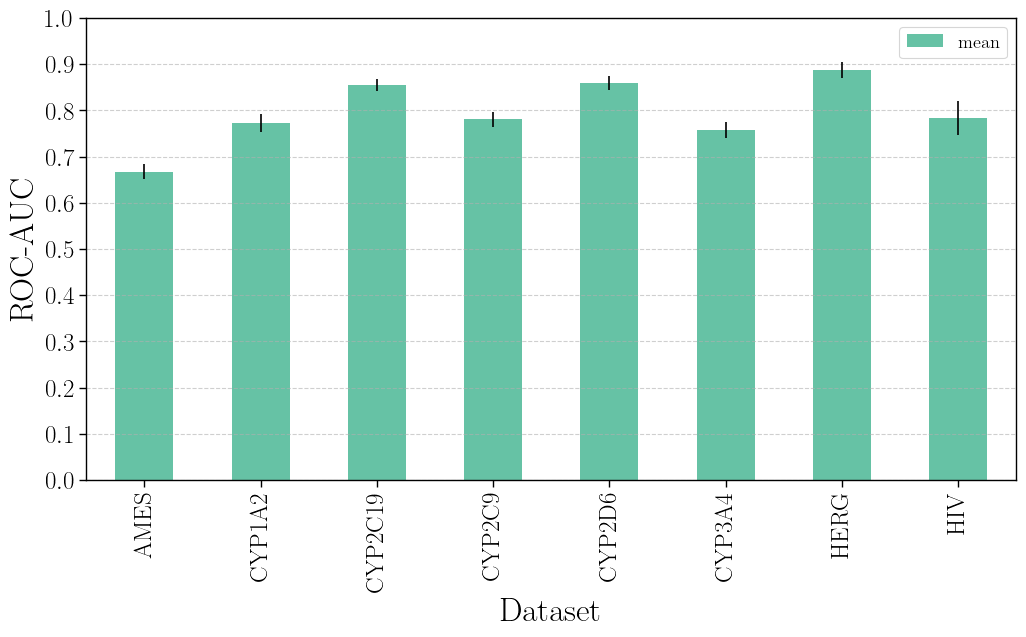

In [106]:
## First, lets have a look on the absolute performance of in distribution on all the datasets. 
## barplot mean and standard deviation of ID_test_roc_auc for each dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

metric_mapping = {'ID_test_accuracy': 'Accuracy', 'ID_test_roc_auc': 'ROC-AUC', 'ID_test_pr_auc': 'PR-AUC'}
chosen_metric = 'ID_test_roc_auc'
results.groupby('dataset')[chosen_metric].agg(['mean', 'std']).plot(kind='bar', y='mean', yerr='std', ax=ax, fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_xlabel("Dataset", fontsize=24)
ax.set_ylabel(metric_mapping[chosen_metric], fontsize=24)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
plt.show()

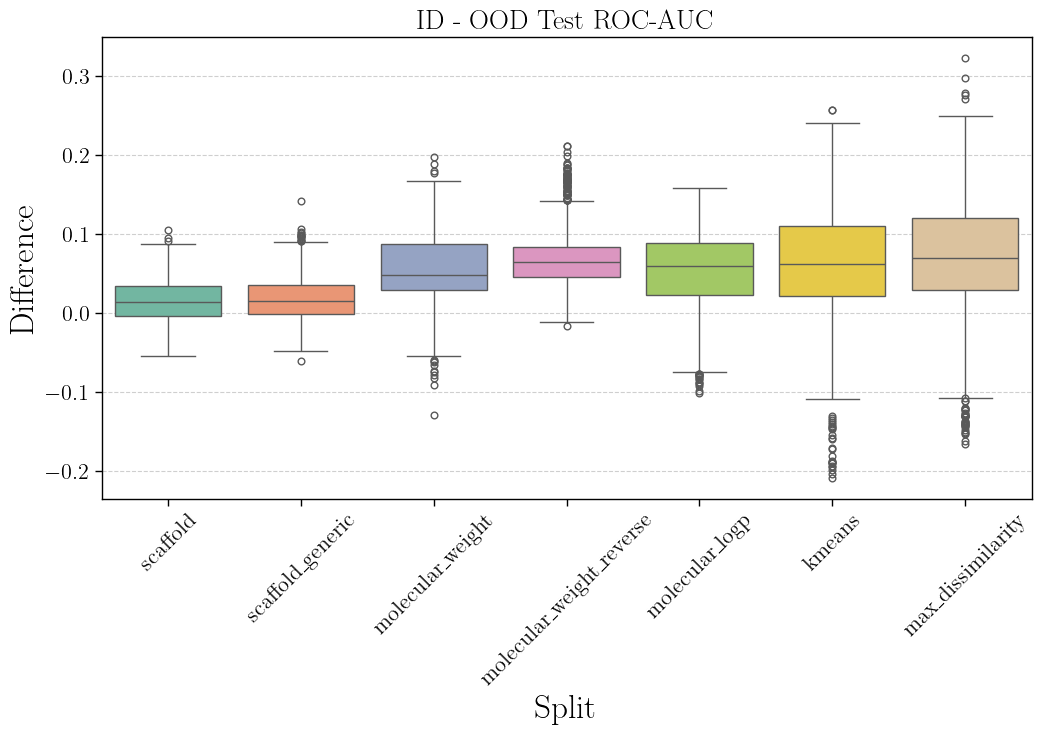

In [107]:
## First, lets have a look on the absolute performance of in distribution on all the datasets. 
## barplot mean and standard deviation of ID_test_roc_auc for each dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# First groupby by the split. Then box plot the differnce between ID_test_roc_auc and OOD_test_roc_auc for each split
metric_mapping = {'ID_test_accuracy': 'Accuracy', 'ID_test_roc_auc': 'ROC-AUC', 'ID_test_pr_auc': 'PR-AUC'}
chosen_metric = 'test_roc_auc'

diff = results[f"ID_{chosen_metric}"] - results[f"OOD_{chosen_metric}"]
results['difference'] = diff
results["model_type"] = results['model'].apply(lambda x: "ML" if x in ML_MODELS else "GNN")

results1= results[results['model'].isin(ML_MODELS)]
results2= results[results['model'].isin(GNN_MODELS)]


sns.boxplot(x="split", y="difference", data=results2, hue="split", ax=ax, showfliers=True)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.title("ID - OOD Test ROC-AUC", fontsize=20)
ax.set_xlabel("Split", fontsize=24)
ax.set_ylabel("Difference", fontsize=24)

ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


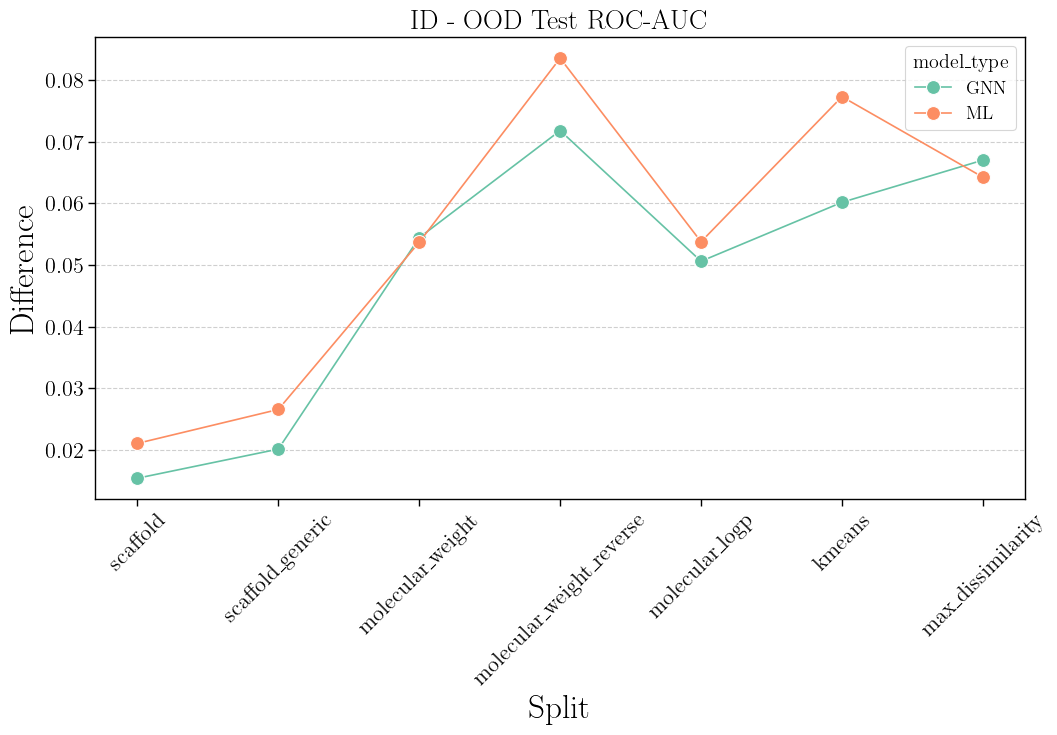

In [108]:
# scatter plot result1 split vs difference column
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df = results.groupby(['split', 'model_type'])['difference'].mean().reset_index()

# rearrange the order of the split
df['split'] = pd.Categorical(df['split'], ["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"])

sns.lineplot(x="split", y="difference", data=df,ax=ax, hue="model_type", marker="o", markersize=10)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.title("ID - OOD Test ROC-AUC", fontsize=20)
ax.set_xlabel("Split", fontsize=24)
ax.set_ylabel("Difference", fontsize=24)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

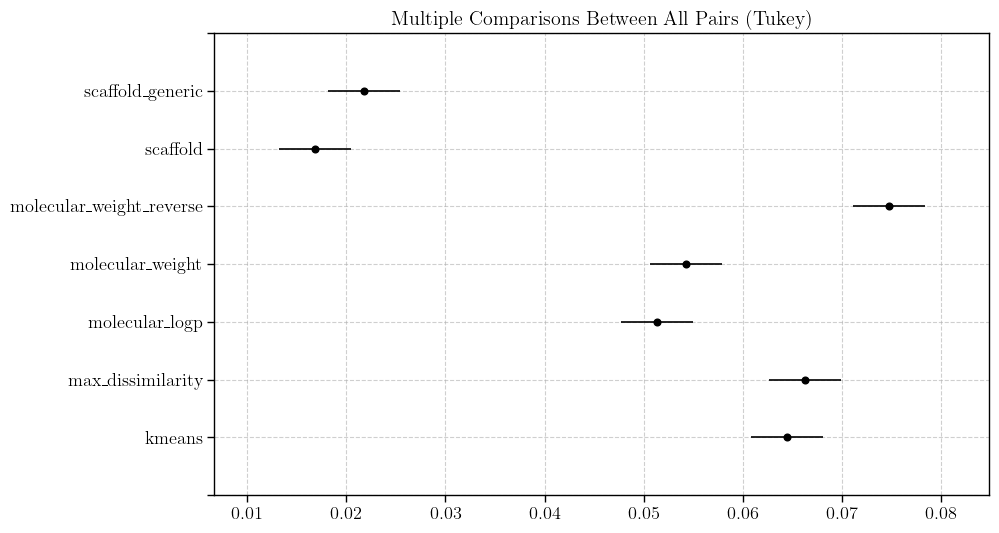

In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform the tukey test
tukey_res = pairwise_tukeyhsd(results.difference, results.split)
_ = tukey_res.plot_simultaneous()
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.show()

In [22]:
results.diff

<bound method DataFrame.diff of       ID_test_accuracy  OOD_test_accuracy  ID_test_roc_auc  OOD_test_roc_auc  \
0             0.712314           0.678640         0.800837          0.756262   
1             0.701168           0.673829         0.794028          0.741239   
2             0.695329           0.669339         0.775159          0.731663   
3             0.704352           0.683772         0.791716          0.755231   
4             0.697983           0.668698         0.788549          0.738714   
...                ...                ...              ...               ...   
6715          0.795603           0.654265         0.875515          0.682525   
6716          0.765201           0.658348         0.867237          0.694499   
6717          0.780168           0.653811         0.880712          0.695003   
6718          0.788120           0.653358         0.878181          0.687051   
6719          0.793732           0.654265         0.884077          0.688505   

      I

In [26]:
## Then lets compare the performance drop for each dataset across each split
results.groupby('dataset')['ID_test_roc_auc'].mean() - results.groupby('dataset')['OOD_test_roc_auc'].mean()

dataset
AMES       0.027510
CYP1A2     0.025746
CYP2C19    0.052641
CYP2C9     0.053300
CYP2D6     0.043125
CYP3A4     0.054722
HERG       0.095652
HIV        0.046866
dtype: float64

In [ ]:
# Just pick the chosen split from all the split in the dataframe
chosen_split = 'max_dissimilarity'
chosen_metric = 'test_roc_auc'
metric_mapping = {'test_accuracy': 'Accuracy', 'test_roc_auc': 'ROC-AUC', 'test_pr_auc': 'PR-AUC'}
df_selected=results[results['split']==chosen_split]

# First, group the results by dataset. then, select ID and OOd performance columns. Then baplot ID and OOd alongside each other
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_selected.groupby('dataset')[[f'ID_{chosen_metric}', f'OOD_{chosen_metric}']].mean().plot(kind='bar', ax=ax, fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_xlabel("Dataset", fontsize=24)
ax.set_ylabel(metric_mapping[chosen_metric], fontsize=24)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
plt.show()


In [ ]:
print(df_selected.groupby('dataset')['ID_test_roc_auc'].mean() - df_selected.groupby('dataset')['OOD_test_roc_auc'].mean())
# same as above, but percentage drop
print((df_selected.groupby('dataset')['ID_test_roc_auc'].mean() - df_selected.groupby('dataset')['OOD_test_roc_auc'].mean())/df_selected.groupby('dataset')['ID_test_roc_auc'].mean())

In [ ]:
df_selected.groupby('dataset')['OOD_test_roc_auc'].mean()

In [ ]:
# combine results for all the datasets in the TDC folder
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
ML_MODELS = cfg["models"]["ML"]
GNN_MODELS = cfg["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS = cfg["models"]["GNN"]["pretrained"]
ALL_MODELS = [ML_MODELS,  GNN_MODELS, PRETRAINED_GNN_MODELS]

In [ ]:
# I want to plot the dfference bwteen ID and OOD for each model in the ALL_MODELS
diff = []
for models in ALL_MODELS:
    results = df_selected[df_selected['model'].isin(models)].copy()
    metrics = ['accuracy', 'roc_auc', 'pr_auc']
    diff_models = []
    for metric in metrics:
        results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
        diff_models.append(results.groupby('model')[f'diff_{metric}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [ ]:
mean_df = pd.DataFrame([diff[0].mean(axis=0), diff[1].mean(axis=0), diff[2].mean(axis=0)], index=["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"])

In [ ]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
mean_df.plot(kind='bar', ax=ax)
ax.set_xlabel("Model", fontsize=20)
ax.set_ylabel("Difference", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()

In [ ]:
# I want to plot the dfference bwteen ID and OOD for each model in the ALL_MODELS for each dataset separately
diff = []
metrics = 'roc_auc'
percentage = True
for models in ALL_MODELS:
    results = df_selected[df_selected['model'].isin(models)].copy()
    diff_models = []
    if percentage:
        results[f'diff_{metrics}'] = (results[f'ID_test_{metrics}'] - results[f'OOD_test_{metrics}']) / results[f'ID_test_{metrics}'] * 100
    else:
        results[f'diff_{metrics}'] = results[f'ID_test_{metrics}'] - results[f'OOD_test_{metrics}']
    diff_models.append(results.groupby(['model', 'dataset'])[f'diff_{metrics}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [ ]:
# for all the datasets, plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
a = pd.DataFrame()
for i in range(3):
    a = pd.concat([a, diff[i].groupby('dataset').mean()], axis=1)
a.columns = ["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"]

In [ ]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=1)
a.plot(kind='bar', ax=ax)
ax.set_xlabel("Dataset", fontsize=20)
ax.set_ylabel("ROC-AUC Difference \%", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()


In [ ]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))

In [ ]:
# First choose a particular dataset. Then for that dataset, plot the performance for all the differet splitting approaches
dataset_name = "HERG"
df = results[results['dataset']==dataset_name]

In [ ]:
ax, fig = plt.subplots(1, 1, figsize=(12, 6))
df.groupby('split')['OOD_test_roc_auc'].mean().plot(kind='bar')
plt.ylabel("ROC-AUC", fontsize=20)
plt.xlabel("Split", fontsize=20)
plt.title(f"OOD ROC-AUC for {dataset_name}", fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# plot the difference between ID and OOD for the dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
perc = True
if perc:
    a= (df.groupby('split')['ID_test_roc_auc'].mean() - df.groupby('split')['OOD_test_roc_auc'].mean())/df.groupby('split')['ID_test_roc_auc'].mean() * 100
    plt.ylabel("ROC-AUC difference \%", fontsize=20)
else:
    a= df.groupby('split')['ID_test_roc_auc'].mean() - df.groupby('split')['OOD_test_roc_auc'].mean()
    plt.ylabel("ROC-AUC difference", fontsize=20)
a.plot(kind='bar')
plt.xlabel("Split", fontsize=20)
plt.title(f"ROC-AUC difference between ID and OOD for {dataset_name}", fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
(df.groupby('split')['ID_test_roc_auc'].mean() - df.groupby('split')['OOD_test_roc_auc'].mean()).plot(kind='bar')

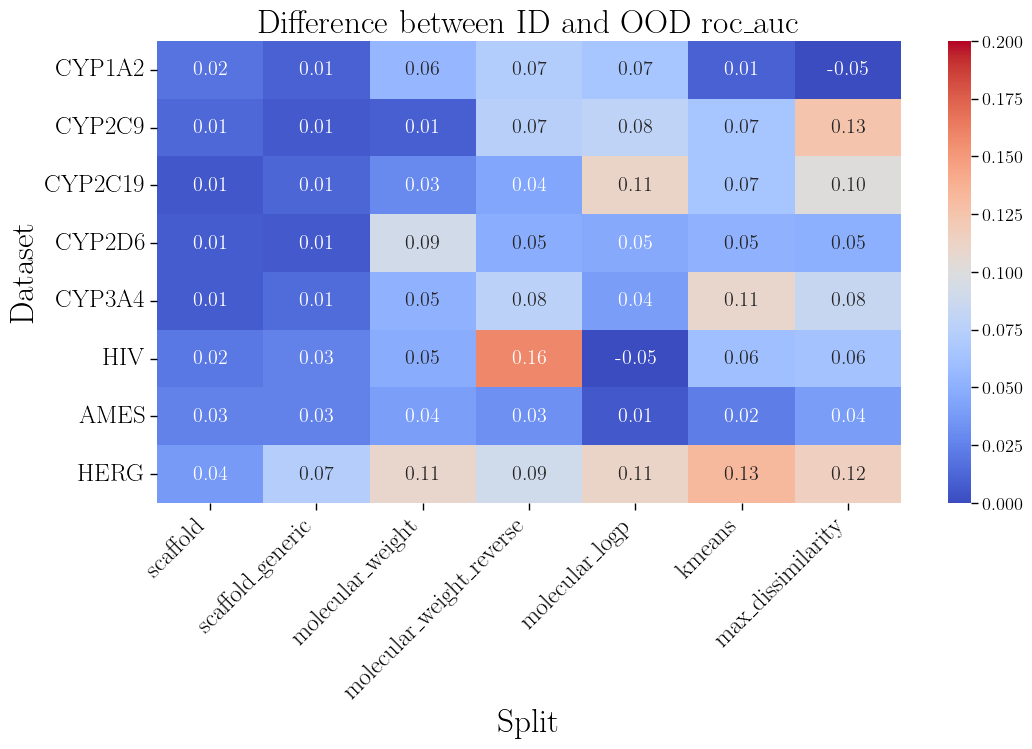

In [4]:
## We want to have a heatmap with one axis datasets and one axis splits. The values in the heatmap are the difference between ID and OOD
## for each dataset and split

results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv")) # read the results
from alinemol.utils.plot_utils import heatmap_plot
heatmap_plot(results, "roc_auc", perc=False, save=False)

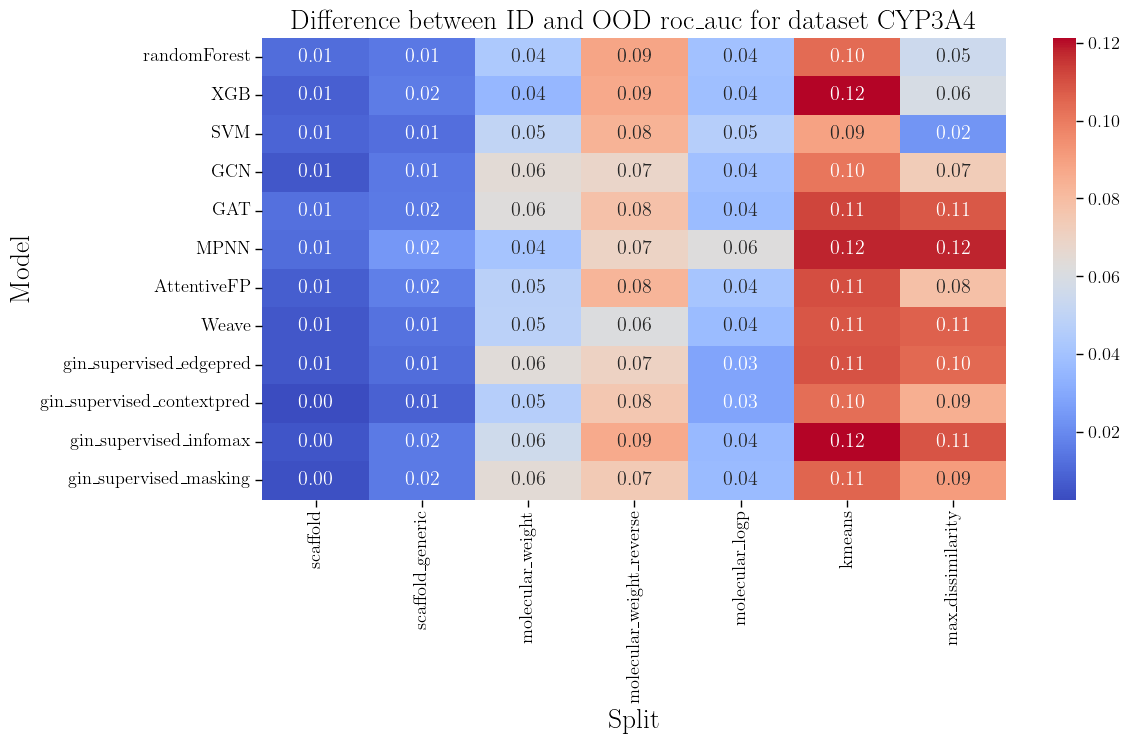

In [5]:
from alinemol.utils.plot_utils import heatmap_plot_dataset_fixed, heeatmap_plot_id_ood

heatmap_plot_dataset_fixed(results, "CYP3A4", "roc_auc", perc=False, save=False)

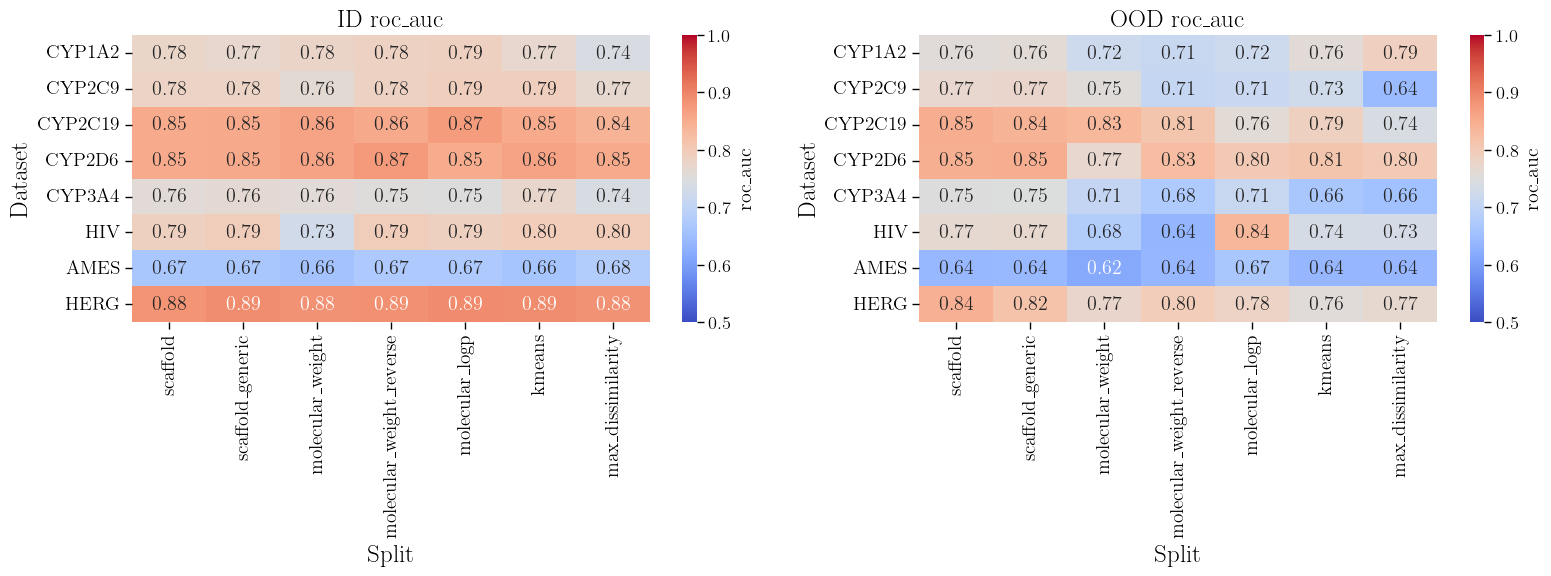

In [6]:
heeatmap_plot_id_ood(results, "roc_auc", perc=False, save=False)

# Model Calibration

In [ ]:
from sklearn.calibration import calibration_curve
dataset_category="TDC"
dataset_names="CYP2C19"
split_type="scaffold"
model_names = ["GCN", "GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax", "randomForest", "SVM", "XGB"]
filename="XGB"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")
# Load your predictions and labels
indices = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(indices):
    df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, filename, str(i + 1), "prediction.csv"))
    y_pred_prob = df["label"].values
    df1 = pd.read_csv(os.path.join(SPLIT_PATH, split_type, f"test_{i}.csv"))
    y_true = df1["label"].values

    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)

    # Plot calibration curve
    ax[i // 5, i % 5].plot(prob_pred, prob_true, marker='o', label=filename)
    ax[i // 5, i % 5].plot([0, 1], [0, 1], linestyle='--', color='black')
    ax[i // 5, i % 5].set_title(f"Calibration plot for split {i + 1}")
    ax[i // 5, i % 5].set_xlabel("Predicted probability")
    ax[i // 5, i % 5].set_ylabel("True probability")
    ax[i // 5, i % 5].legend()
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import brier_score_loss

def brier_score(y_true, y_pred_prob):
    brier_score = brier_score_loss(y_true, y_pred_prob)
    return brier_score

In [ ]:
def expected_calibration_error(y_true, y_pred_prob, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_pred_prob >= bin_lower) & (y_pred_prob < bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(y_true[in_bin])
            avg_pred_prob_in_bin = np.mean(y_pred_prob[in_bin])
            ece += np.abs(avg_pred_prob_in_bin - accuracy_in_bin) * prop_in_bin

    return ece



In [ ]:
# Calculate ECE and Brier Score
ece = expected_calibration_error(y_true, y_pred_prob)
brier = brier_score(y_true, y_pred_prob)
print(f"Expected Calibration Error (ECE): {ece}")
print(f"Brier Score: {brier}")

In [ ]:
# Calculate ECE and Brier Score for all datasets, all models and all splits
import yaml
cfg = yaml.safe_load(open(os.path.join(DATASET_PATH, 'config.yml'), 'r'))

dataset_category="TDC"
dataset_names= cfg["datasets"][dataset_category]
split_types= cfg["splitting"]
model_names = cfg["models"]["ML"] + cfg["models"]["GNN"]["scratch"] + cfg["models"]["GNN"]["pretrained"]

results = []
for dataset in dataset_names:
    for split_type in split_types:
        for model in model_names:
            for i in range(10):
                df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset, split_type, model, str(i + 1), "prediction.csv"))
                y_pred_prob = df["label"].values
                df1 = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset, "split", split_type, f"test_{i}.csv"))
                y_true = df1["label"].values
                ece = expected_calibration_error(y_true, y_pred_prob)
                brier = brier_score(y_true, y_pred_prob)
                results.append({"dataset": dataset, "split": split_type, "model": model, "ECE": ece, "Brier Score": brier})

results = pd.DataFrame(results)


In [ ]:
filter_dataset = "AMES"
dataset_results = results[results["dataset"]==filter_dataset]
dataset_results.groupby('split')['ECE'].mean()

## Molecular weight analysis

In [ ]:
# First calculate molecular weight for train and test set. Then, break down the test set to three different bins based on molecular weight
# Then, find out the prediction on each bin, and then calculate accuracy for each bin

dataset_category="TDC"
dataset_names="CYP2D6"
split_type="molecular_weight"
model_name="randomForest"
# do that for all index from 1 to 10
index = 1
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

accuracy_list = []
# Load your predictions and labels
for index in range(0, 10):
    df = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, model_name, str(index + 1), "prediction.csv"))
    df1 = pd.read_csv(os.path.join(SPLIT_PATH, split_type, f"test_{index}.csv"))

    # Compute molecular weight
    df1["mw"] = df1["smiles"].apply(lambda x: dm.descriptors.mw(dm.to_mol(x)))

    df["prediction"] = df["label"] > 0.5
    df["label"] = df1["label"]

    # Break down the test set to three different bins based on molecular weight
    bins_range = [min(df1["mw"])-0.0001, df1["mw"].quantile(0.4), df1["mw"].quantile(0.8), max(df1["mw"]+0.0001)]

    # Find out the prediction on each bin
    df["mw"] = df1["mw"]
    df["bin"] = pd.cut(df["mw"], bins=bins_range, labels=["low", "medium", "high"])

    # Calculate accuracy for each bin
    accuracy = df.groupby("bin").apply(lambda x: (x["label"] == x["prediction"]).mean())
    print(f"Accuracy for split {index}")
    accuracy_list.append(accuracy)


In [ ]:
# Plot the accuracy for each bin with mean and standard deviation
accuracy_df = pd.concat(accuracy_list, axis=1).T

# determine mean and standard deviation for each columns and then plot barplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
accuracy_df.mean().plot(kind='bar', ax=ax, yerr=accuracy_df.std())
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Bin", fontsize=20)
plt.title(f"Accuracy for {dataset_names} dataset", fontsize=20)
plt.xticks(fontsize=18, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
df["bin"].value_counts()

In [ ]:
bins_range

# Calculate TMD

In [ ]:
# just read the datasets and concatanate their smiles column
dataset_category="TDC"
dataset_names = ["CYP2C19", "CYP2C9", "CYP3A4", "CYP1A2", "HERG", "AMES"]
smiles = []
for dataset in dataset_names:
    df = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset, f"{dataset}_standardize.csv"))
    smiles.append(df["smiles"])
smiles = pd.concat(smiles)



In [ ]:
# calculate the unique smiles and keep just the unique smiles
print(f"Number of smiles: {smiles.shape[0]}")
smiles = smiles.drop_duplicates()
print(f"Number of unique smiles: {smiles.shape[0]}")

# save this into three different files with three different chunks of smiles
keep = smiles.shape[0] // 3
smiles[:keep].to_csv(os.path.join(DATASET_PATH,"smiles1.csv"), index=False)
smiles[keep:2*keep].to_csv(os.path.join(DATASET_PATH,"smiles2.csv"), index=False)
smiles[2*keep:].to_csv(os.path.join(DATASET_PATH,"smiles3.csv"), index=False)

In [ ]:
smiles.to_csv(os.path.join(DATASET_PATH,"smiles.csv"), index=False)


In [ ]:
df = pd.read_csv("datasets/TDC/HERG/HERG_standardize.csv")
smiles = df["smiles"].values
split = MolecularLogPSplit(n_splits=1)

for train_index, test_index in split.split(smiles):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

# calculate  clogp for each molecule in the train and test set, then plot the histogram

train["clogp"] = train["smiles"].apply(lambda x: dm.descriptors.clogp(dm.to_mol(x)))
test["clogp"] = test["smiles"].apply(lambda x: dm.descriptors.clogp(dm.to_mol(x)))

# Plot the histogram of the clogp in the train and test split
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(train["clogp"], label="train", ax=ax)
sns.histplot(test["clogp"], label="test", ax=ax)
ax.set_xlabel("CLogP", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title(f"CLogP distribution in train and test split", fontsize=18)
ax.legend()
plt.show()


In [ ]:
# plot one mocleule with larg logp and one with small logp
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# plot the molecule with the smallest logp and largest logp along with their smiles
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
smallest_clogp = train.loc[train["clogp"].idxmin()]
largest_clogp = test.loc[test["clogp"].idxmax()]
smallest_mol = dm.to_mol(smallest_clogp["smiles"])
largest_mol = dm.to_mol(largest_clogp["smiles"])

# I have two mol object. I want to plot them alongside each other with their logp
mols = [smallest_mol, largest_mol]
Draw.MolsToGridImage(mols,subImgSize=(250,200))




In [ ]:
# do the same with the ssix lowest and six highest logp
train = train.sort_values("clogp")
test = test.sort_values("clogp")

# plot the molecule with the smallest logp and largest logp along with their smiles
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
smallest_clogp = train.iloc[:6]
largest_clogp = test.iloc[-6:]
smallest_mol = [dm.to_mol(smiles) for smiles in smallest_clogp["smiles"]]
largest_mol = [dm.to_mol(smiles) for smiles in largest_clogp["smiles"]]
mols = smallest_mol + largest_mol
Draw.MolsToGridImage(mols,subImgSize=(250,200))


# Comparing Two or more splits together

In [ ]:
split_type1="scaffold"
split_type2="molecular_weight"
dataset_name="CYP3A4"
metrics = "accuracy"
results1 = pd.read_csv(os.path.join("classification_results", "TDC", dataset_name, split_type1, "results.csv"))
results2 = pd.read_csv(os.path.join("classification_results", "TDC", dataset_name, split_type2, "results.csv"))

## keep the ID and OOd accuracy columns for each split type
results1 = results1[['model', f'ID_test_{metrics}', f'OOD_test_{metrics}']]
results2 = results2[['model', f'ID_test_{metrics}', f'OOD_test_{metrics}']]

## concat results1 and results2 on axis 1 and change the duplicate columns name
results = pd.concat([results1, results2], axis=1)
results.columns = [f"{col}_{split_type1}" if col != "model" else col for col in results1.columns] + [f"{col}_{split_type2}" if col != "model" else col for col in results2.columns]
# keep only one of the model column
results = results.loc[:,~results.columns.duplicated()]
## if model is in XGB, rf and SVM, onsider them as ML models, otherwise GNN models
results["model_type"] = np.where(results["model"].isin(["XGB", "randomForest", "SVM"]), "ML", "GNN")

In [ ]:
results

In [ ]:
results["model_type"].value_counts()

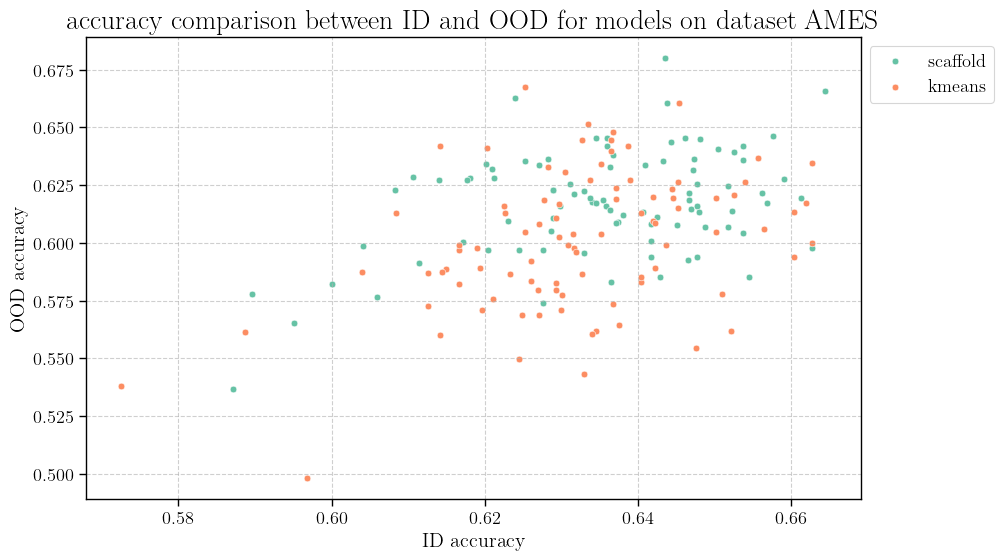

In [110]:
# sctatter plot of ID_test_accuracy vs OOD test accuracy for each split type on the same plot
results = pd.read_csv(os.path.join("classification_results", "TDC" , "results.csv"))
# from results, just pick up GNNs part
results = results[results["model"].isin(GNN_MODELS)]
from alinemol.utils.plot_utils import dataset_fixed_split_comparisson
dataset_fixed_split_comparisson(results, "AMES", "scaffold", "kmeans", "accuracy", save=False)


In [111]:
# plot the same for ML and then for GNN seprarately
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x=f'ID_test_{metrics}_{split_type1}', y=f'OOD_test_{metrics}_{split_type1}', data=results[results["model_type"]=="ML"], ax=ax, s=40)
sns.scatterplot(x=f'ID_test_{metrics}_{split_type2}', y=f'OOD_test_{metrics}_{split_type2}', data=results[results["model_type"]=="ML"], ax=ax, s=40)
plt.xlabel(f"ID {metrics}", fontsize=20)
plt.ylabel(f"OOD {metrics}", fontsize=20)
plt.title(f"{metrics} comparison between ID and OOD for ML models", fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.legend([split_type1, split_type2])
plt.show()

NameError: name 'metrics' is not defined

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(x=f'ID_test_{metrics}_{split_type1}', y=f'OOD_test_{metrics}_{split_type1}', data=results[results["model_type"]=="GNN"], ax=ax, s=40)
sns.scatterplot(x=f'ID_test_{metrics}_{split_type2}', y=f'OOD_test_{metrics}_{split_type2}', data=results[results["model_type"]=="GNN"], ax=ax, s=40)
plt.xlabel(f"ID {metrics}", fontsize=20)
plt.ylabel(f"OOD {metrics}", fontsize=20)
plt.title(f"{metrics} comparison between ID and OOD for GNN models", fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.show()

NameError: name 'metrics' is not defined

In [ ]:
results

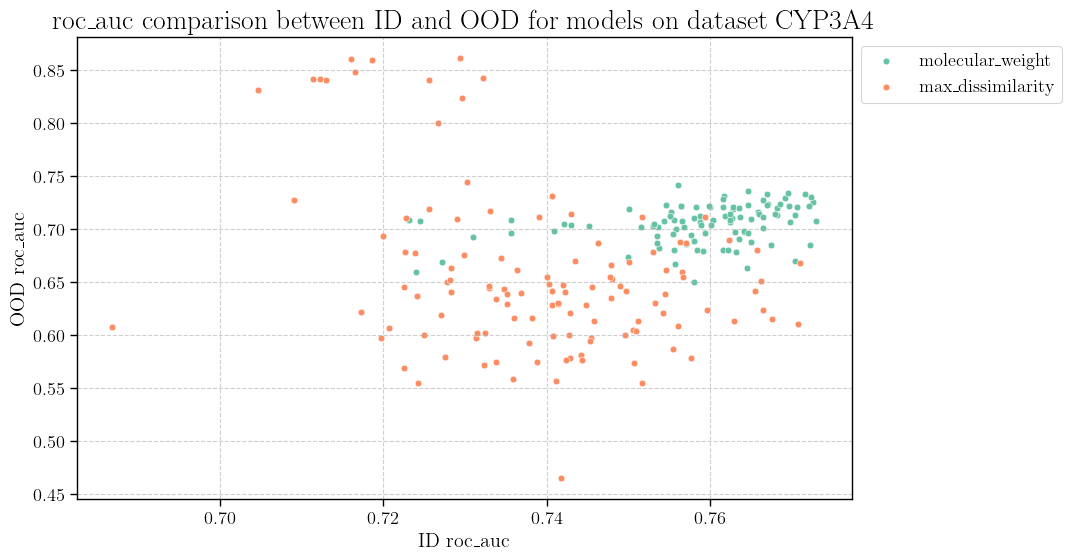

In [114]:
from alinemol.utils.plot_utils import dataset_fixed_split_comparisson
dataset_fixed_split_comparisson(None, "CYP3A4", "molecular_weight", "max_dissimilarity", metric="roc_auc", save=False)

In [170]:
## For the ID and OOD metric for one dataset and one split, fit a line and calculate the slope and intercept
import statsmodels.api as sm
dataset_category="TDC"
dataset_name="CYP1A2"
split_type="kmeans"
metrics = "roc_auc"
results = pd.read_csv(os.path.join("classification_results", dataset_category, "results.csv"))
results = results[(results["dataset"]==dataset_name) & (results["split"]==split_type)]
results = results[["model", f"ID_test_{metrics}", f"OOD_test_{metrics}"]]
results = results.dropna()

## pick the results in GNN models
results = results[results["model"].isin(GNN_MODELS + PRETRAINED_GNN_MODELS)]

X = results[f"ID_test_{metrics}"].values.reshape(-1, 1)
y = results[f"OOD_test_{metrics}"].values


covs = sm.add_constant(X, prepend=True)
model = sm.OLS(y, covs)
fitted = model.fit()
print(fitted.params, fitted.rsquared)

[ 3.26535992 -3.25041809] 0.8576508995907448


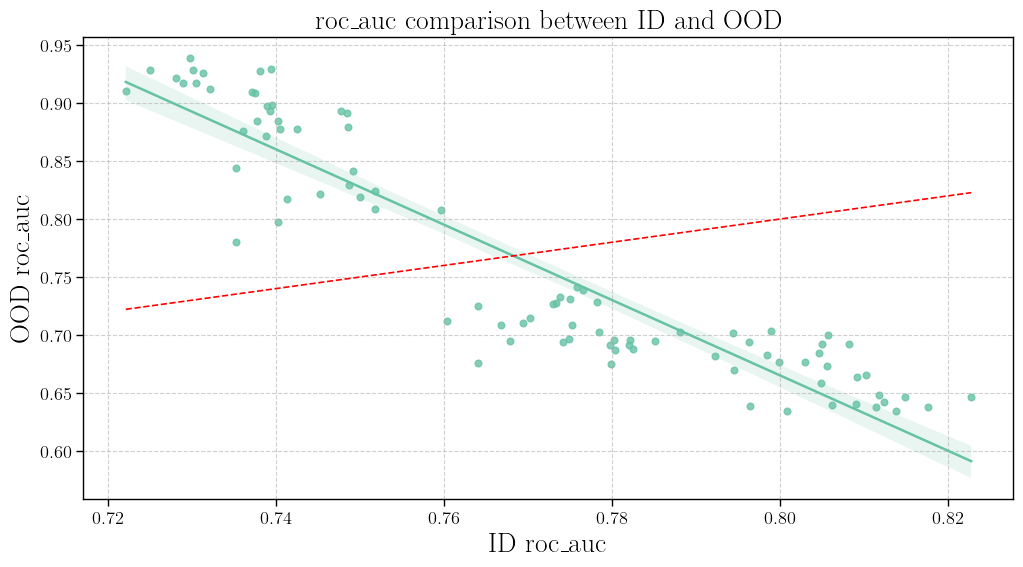

In [171]:
# plot the at IID and OOD with the fitted line

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.regplot(x=f"ID_test_{metrics}", y=f"OOD_test_{metrics}", data=results, ax=ax)
#add  y = x line to the plot and zoom just on the reg plot part
sns.lineplot(x=f"ID_test_{metrics}", y=f"ID_test_{metrics}", data=results, ax=ax, color='red', linestyle='--')
plt.xlabel(f"ID {metrics}", fontsize=20)
plt.ylabel(f"OOD {metrics}", fontsize=20)
plt.title(f"{metrics} comparison between ID and OOD", fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.show()

In [145]:
# calculate linear coefficient and r squared for all the datasets and splits
import statsmodels.api as sm
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
datasets = cfg["datasets"][dataset_category]
ML_MODELS = cfg["models"]["ML"]
GNN_MODELS = cfg["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS = cfg["models"]["GNN"]["pretrained"]
GNNS = [GNN_MODELS + PRETRAINED_GNN_MODELS]
ALL_MODELS = [ML_MODELS,  GNN_MODELS + PRETRAINED_GNN_MODELS]
splits = cfg["splitting"]
metrics = "accuracy"
results_list = []
df = pd.read_csv(os.path.join("classification_results", dataset_category, "results.csv"))
for dataset in datasets:
    for split in splits:
        results = df[(df["dataset"]==dataset) & (df["split"]==split)]
        results = results[["model", f"ID_test_{metrics}", f"OOD_test_{metrics}"]]
        results = results.dropna()
        # Just fit for ML Models
        for models in GNNS:
            a = results[results["model"].isin(models)]
            X = a[f"ID_test_{metrics}"].values.reshape(-1, 1)
            y = a[f"OOD_test_{metrics}"].values
            covs = sm.add_constant(X, prepend=True)
            model = sm.OLS(y, covs)
            fitted = model.fit()
            results_list.append({"dataset": dataset, "split": split, "model": models, "slope": fitted.params[1], "intercept": fitted.params[0], "r_squared": fitted.rsquared})

results = pd.DataFrame(results_list)
results

,dataset,split,model,slope,intercept,r_squared
0,CYP1A2,scaffold,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.211119,0.532153,0.025772
1,CYP1A2,scaffold_generic,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.407757,0.400682,0.076346
2,CYP1A2,molecular_weight,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.306343,0.467980,0.029139
3,CYP1A2,molecular_weight_reverse,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.103970,0.587334,0.007815
4,CYP1A2,molecular_logp,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.172187,0.525215,0.035785
5,CYP1A2,kmeans,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",-3.157466,2.860515,0.713708
6,CYP1A2,max_dissimilarity,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",1.885959,-0.584731,0.071727
7,CYP2C9,scaffold,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.751797,0.173137,0.316737
8,CYP2C9,scaffold_generic,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.918792,0.054428,0.538137
9,CYP2C9,molecular_weight,"[GCN, GAT, MPNN, AttentiveFP, Weave, gin_super...",0.246942,0.508031,0.014543


In [146]:
slope = results.pivot(index="split", columns="dataset", values="slope")
r_squared = results.pivot(index="split", columns="dataset", values="r_squared")

In [147]:
# sort columns based on the given order
slope = slope[datasets]
slope = slope.reindex(splits)
slope = slope.astype(float).round(2)

r_squared = r_squared[datasets]
r_squared = r_squared.reindex(splits)
r_squared = r_squared.astype(float).round(2)

formatted = slope.astype(str) + " (" + r_squared.astype(str) + ")"

In [148]:
formatted

dataset,CYP1A2,CYP2C9,CYP2C19,CYP2D6,CYP3A4,HIV,AMES,HERG
split,,,,,,,,
scaffold,0.21 (0.03),0.75 (0.32),0.21 (0.04),0.49 (0.28),0.4 (0.13),0.65 (0.45),0.58 (0.17),0.68 (0.57)
scaffold_generic,0.41 (0.08),0.92 (0.54),0.38 (0.18),0.47 (0.16),0.67 (0.38),0.47 (0.26),-0.06 (0.0),0.56 (0.29)
molecular_weight,0.31 (0.03),0.25 (0.01),1.0 (0.36),1.2 (0.57),-0.03 (0.0),-0.24 (0.01),0.39 (0.24),0.54 (0.46)
molecular_weight_reverse,0.1 (0.01),0.39 (0.05),-0.23 (0.03),0.38 (0.1),1.38 (0.51),0.81 (0.37),0.44 (0.14),0.28 (0.1)
molecular_logp,0.17 (0.04),0.96 (0.49),0.57 (0.24),1.45 (0.5),0.42 (0.32),0.99 (0.59),0.36 (0.18),0.47 (0.46)
kmeans,-3.16 (0.71),-0.54 (0.05),1.12 (0.04),0.28 (0.03),0.7 (0.29),0.6 (0.08),0.74 (0.15),0.17 (0.02)
max_dissimilarity,1.89 (0.07),1.22 (0.06),-2.58 (0.08),1.04 (0.31),-0.19 (0.01),0.25 (0.03),0.3 (0.05),0.3 (0.06)


In [150]:
formatted.to_latex(escape=False, index=False, float_format="%.2f", buf="assets/slope.tex")

In [ ]:
# calculate linear coefficient and r squared for all the datasets and splits
import statsmodels.api as sm
import yaml
dataset_category="TDC"
with open(os.path.join(DATASET_PATH, 'config.yml'), 'r') as f:
    cfg = yaml.safe_load(f)
datasets = cfg["datasets"][dataset_category]
ML_MODELS = cfg["models"]["ML"]
GNN_MODELS = cfg["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS = cfg["models"]["GNN"]["pretrained"]
ALL_MODELS = [ML_MODELS,  GNN_MODELS, PRETRAINED_GNN_MODELS]
splits = cfg["splitting"]
metrics = "accuracy"
results_list = []
df = pd.read_csv(os.path.join("classification_results", dataset_category, "results.csv"))
for dataset in datasets:
    for split in splits:
        results = df[(df["dataset"]==dataset) & (df["split"]==split)]
        results = results[["model", f"ID_test_{metrics}", f"OOD_test_{metrics}"]]
        results = results.dropna()
        a = results
        # Just fit for ML Models
        X = a[f"ID_test_{metrics}"].values.reshape(-1, 1)
        y = a[f"OOD_test_{metrics}"].values
        covs = sm.add_constant(X, prepend=True)
        model = sm.OLS(y, covs)
        fitted = model.fit()
        results_list.append({"dataset": dataset, "split": split, "model": models, "slope": fitted.params[1], "intercept": fitted.params[0], "r_squared": fitted.rsquared})

b = pd.DataFrame(results_list)
b

In [ ]:
# for b dataframe can you remove intercept, put dataset on columns adn split on index
# report the slope adn r_squared for each dataset and split
c = b.pivot(index="split", columns="dataset", values="slope")
d = b.pivot(index="split", columns="dataset", values="r_squared")

In [ ]:
# sort columns based on the given order
c = c[datasets]
c = c.reindex(splits)
c.round(2)

d = d[datasets]
d = d.reindex(splits)
d.round(2)

In [ ]:
d.to_latex(index=False, buf="assets/slope.tex", float_format="%.2f")

In [ ]:
# group by the results by split and then calculate the mean and standard deviation of the slope and r squared
results.groupby('split')[['slope', 'r_squared']].agg(['mean', 'std'])


In [ ]:
# export this results into google docs

In [ ]:
sns.set_palette("Set2")
light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))

In [ ]:
dataset_names = results["dataset"].unique()  # get the unique dataset names
#split_types = results["split"].unique()  # get the unique split types
split_types = ["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"]
models = results["model"].unique()  # get the unique models
metric = "roc_auc"
vmin, vnmax = 0.0, 0.2
# We want subplots for fixing each time one dataset, then plot the heatmap od difference between ID and OOd for all the modles and split types with 
# the same dataset
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i, dataset in enumerate(dataset_names):
    result_subset = results[results["dataset"]==dataset]
    df = pd.DataFrame(index=models, columns=split_types)

    for model in models:
        for split in split_types:
            num = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"ID_test_{metric}"].mean()
            den = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"OOD_test_{metric}"].mean()
            df.loc[model, split] = num - den
    
    df = df.astype(float)
    sns.heatmap(df, ax=ax[i // 2, i % 2], annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': f"{metric} difference"}, vmin=vmin, vmax=vnmax)
    ax[i // 2, i % 2].set_title(f"{dataset}", fontsize=18)
    ax[i // 2, i % 2].set_xlabel("Split", fontsize=18)
    ax[i // 2, i % 2].set_ylabel("Model", fontsize=18)
    #ax[i // 2, i % 2].tick_params(axis='both', which='major', labelsize=14)

    ax[i // 2, i % 2].set_xlabel("")
    ax[i // 2, i % 2].set_ylabel("")

    # just keep the xticks (ax.set_xticks) for left plots and yticks (ax.set_yticks) for bottom plots
    if i % 2 == 0:
        ax[i // 2, i % 2].set_yticks(np.arange(len(models)) + 0.5)
        ax[i // 2, i % 2].set_yticklabels(models, fontsize=18)
        ax[i // 2, i % 2].set_xticks([])
    else:
        ax[i // 2, i % 2].set_xticks([])
        ax[i // 2, i % 2].set_yticks([])
    #if i // 2 == 3:
    #    ax[i // 2, i % 2].set_yticks(np.arange(len(models)) + 0.5)
    #    ax[i // 2, i % 2].set_yticklabels(models)
    #else:
    #    ax[i // 2, i % 2].set_yticks([])
    
    
    ax[3, 0].set_xticks(np.arange(len(split_types)) + 0.5)
    ax[3, 0].set_xticklabels(split_types, rotation=90, fontsize=18)
    ax[3, 1].set_xticks(np.arange(len(split_types)) + 0.5)
    ax[3, 1].set_xticklabels(split_types, rotation=90, fontsize=18)

plt.tight_layout()
# save the plot to pdf
plt.savefig("assets/datasets_heatmap_rocauc.pdf", bbox_inches="tight",backend="pgf")
plt.show()

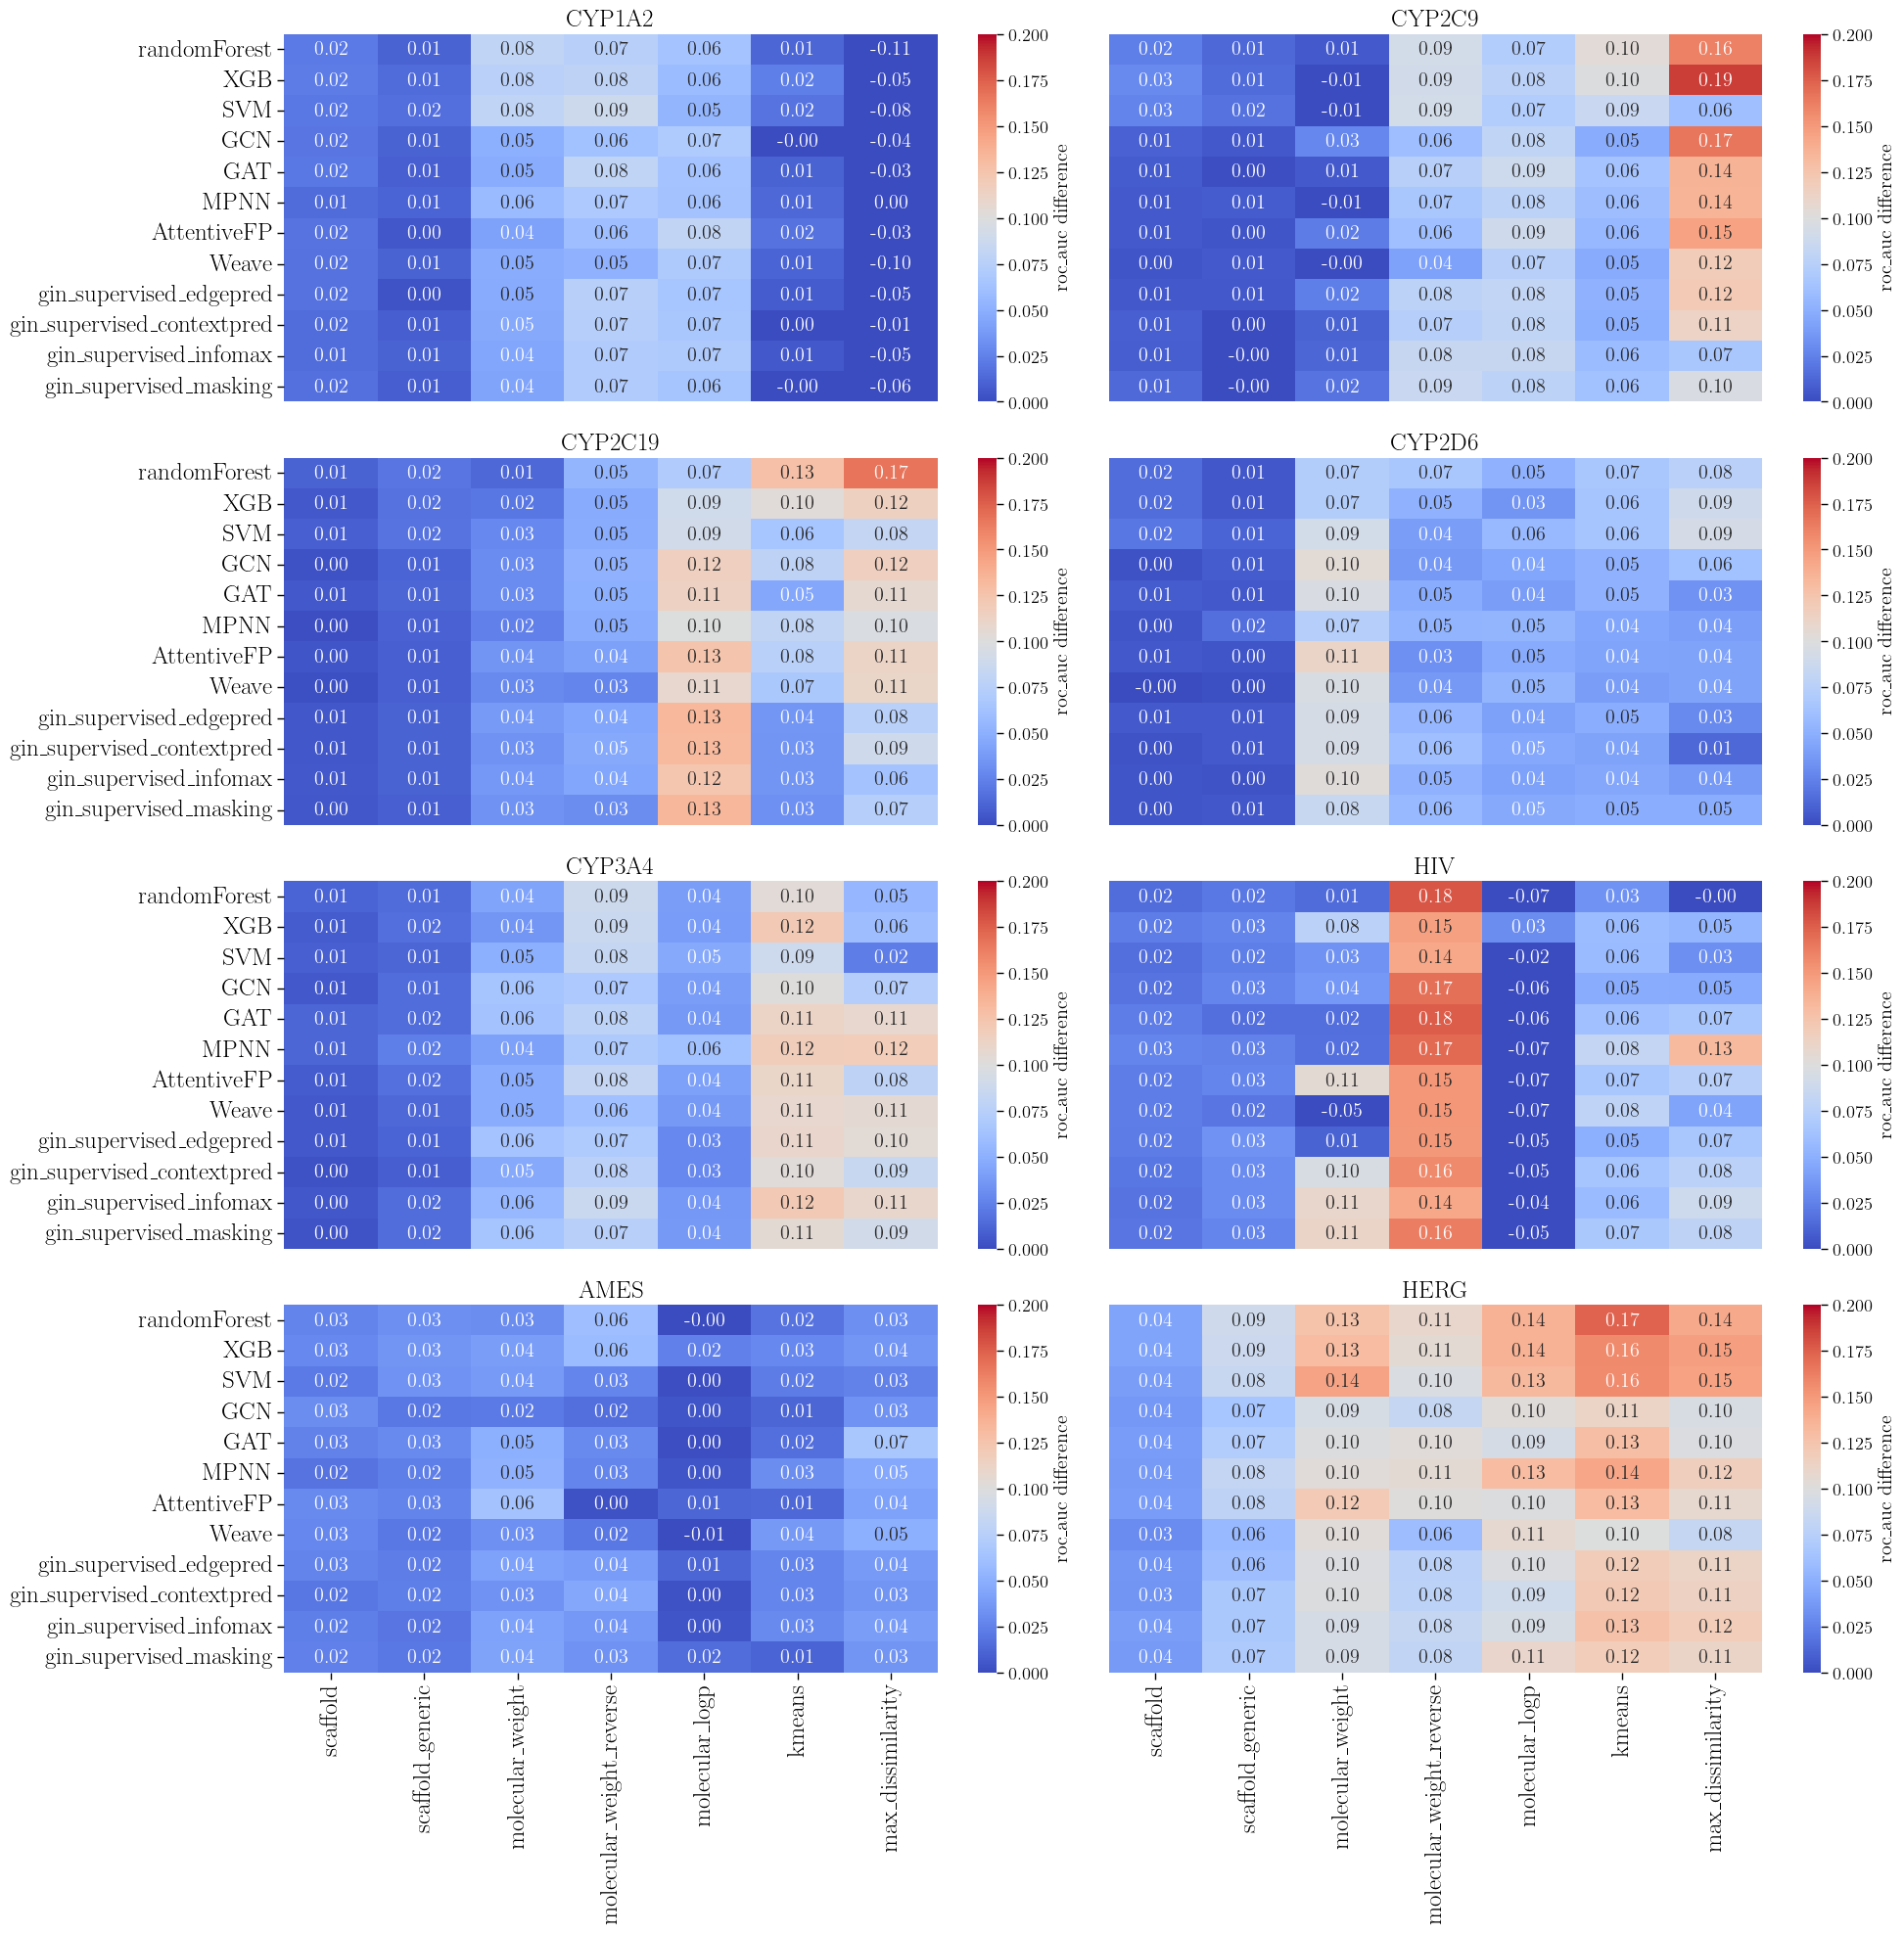

In [46]:
from alinemol.utils.plot_utils import heatmap_plot_all_dataset
heatmap_plot_all_dataset(results=None, metric = "roc_auc", report="diff", save=False)

In [ ]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))
CFG = yaml.safe_load(open(os.path.join("datasets", "config.yml"), "r"))

ML_MODELS = CFG["models"]["ML"]
GNN_MODELS = CFG["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS = CFG["models"]["GNN"]["pretrained"]
ALL_MODELS = [ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS]

dataset_names = results["dataset"].unique()  # get the unique dataset names
#split_types = results["split"].unique()  # get the unique split types
split_types = ["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"]
models = results["model"].unique()  # get the unique models
metric = "accuracy"
vmin, vnmax = 0.0, 0.2
# We want subplots for fixing each time one dataset, then plot the heatmap od difference between ID and OOd for all the modles and split types with 
# the same dataset
f_mean ={}
f_std = {}
f_diff_mean = {}
f_diff_std = {}
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i, dataset in enumerate(dataset_names):
    result_subset = results[results["dataset"]==dataset]
    mean_df = pd.DataFrame(index=models, columns=split_types)
    std_df = pd.DataFrame(index=models, columns=split_types)
    diff_mean = pd.DataFrame(index=models, columns=split_types)
    diff_std = pd.DataFrame(index=models, columns=split_types)

    for model in models:
        for split in split_types:
            mean_id = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"ID_test_{metric}"].mean()
            mean_ood = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"OOD_test_{metric}"].mean()
            std_id = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"ID_test_{metric}"].std()
            std_ood = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"OOD_test_{metric}"].std()
            diff = result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"ID_test_{metric}"] - result_subset[(result_subset["model"] == model) & (result_subset["split"] == split)][f"OOD_test_{metric}"]
            mean_df.loc[model, split] = mean_ood
            std_df.loc[model, split] = std_ood
            diff_mean.loc[model, split] = diff.mean()
            diff_std.loc[model, split] = diff.std()
    
    # jst for the models index, devide them into ML, GNN and PRETRAINED_GNN and calculate average performance for each
    mean_df.index = np.where(mean_df.index.isin(ML_MODELS), "ML", np.where(mean_df.index.isin(GNN_MODELS), "GNN", "PRETRAINED_GNN"))
    std_df.index = np.where(std_df.index.isin(ML_MODELS), "ML", np.where(std_df.index.isin(GNN_MODELS), "GNN", "PRETRAINED_GNN"))
    diff_mean.index = np.where(diff_mean.index.isin(ML_MODELS), "ML", np.where(diff_mean.index.isin(GNN_MODELS), "GNN", "PRETRAINED_GNN"))
    diff_std.index = np.where(diff_std.index.isin(ML_MODELS), "ML", np.where(diff_std.index.isin(GNN_MODELS), "GNN", "PRETRAINED_GNN"))

    mean_df = mean_df.groupby(mean_df.index).mean()
    mean_df = mean_df.astype(float)
    f_mean[dataset] = mean_df.round(2)

    std_df = std_df.groupby(std_df.index).mean()
    std_df = std_df.astype(float)
    f_std[dataset] = std_df.round(2)

    diff_mean = diff_mean.groupby(diff_mean.index).mean()
    diff_mean = diff_mean.astype(float)
    f_diff_mean[dataset] = diff_mean.round(2)

    diff_std = diff_std.groupby(diff_std.index).mean()
    diff_std = diff_std.astype(float)
    f_diff_std[dataset] = diff_std.round(2)

    """
    

    # plor the heatmap
    sns.heatmap(df, ax=ax[i // 2, i % 2], annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': f"{metric} difference"}, vmin=vmin, vmax=vnmax)
    ax[i // 2, i % 2].set_title(f"{dataset}", fontsize=18)
    ax[i // 2, i % 2].set_xlabel("Split", fontsize=18)
    ax[i // 2, i % 2].set_ylabel("Model", fontsize=18)
    #ax[i // 2, i % 2].tick_params(axis='both', which='major', labelsize=14)

    ax[i // 2, i % 2].set_xlabel("")
    ax[i // 2, i % 2].set_ylabel("")
    # just keep the xticks (ax.set_xticks) for left plots and yticks (ax.set_yticks) for bottom plots

    if i % 2 == 0:
        #ax[i // 2, i % 2].set_yticks(np.arange(len(models)) + 0.5)
        #ax[i // 2, i % 2].set_yticklabels(models, fontsize=18)
        ax[i // 2, i % 2].set_xticks([])
    else:
        ax[i // 2, i % 2].set_xticks([])
        #ax[i // 2, i % 2].set_yticks([])
    #if i // 2 == 3:
    #    ax[i // 2, i % 2].set_yticks(np.arange(len(models)) + 0.5)
    #    ax[i // 2, i % 2].set_yticklabels(models)
    #else:
    #    ax[i // 2, i % 2].set_yticks([])

    ax[3, 0].set_xticks(np.arange(len(split_types)) + 0.5)
    ax[3, 0].set_xticklabels(split_types, rotation=90, fontsize=18)
    ax[3, 1].set_xticks(np.arange(len(split_types)) + 0.5)
    ax[3, 1].set_xticklabels(split_types, rotation=90, fontsize=18)

plt.tight_layout()
plt.show()
"""

In [ ]:
# for f, put split on the rows and dataset on the columns and create new dataframe
df_mean = pd.DataFrame()
df_std = pd.DataFrame()
for dataset in dataset_names:
    df_mean[dataset] = f_diff_mean[dataset].loc["PRETRAINED_GNN"]
    df_std[dataset] = f_diff_std[dataset].loc["PRETRAINED_GNN"]

In [ ]:
formatted = df_mean.astype(str) + " (" + df_std.astype(str) + ")"

In [ ]:
# Convert to LaTeX
latex_table = formatted.to_latex(escape=False, index=False, float_format="{:.2f}".format, buf="assets/ML_models.tex")

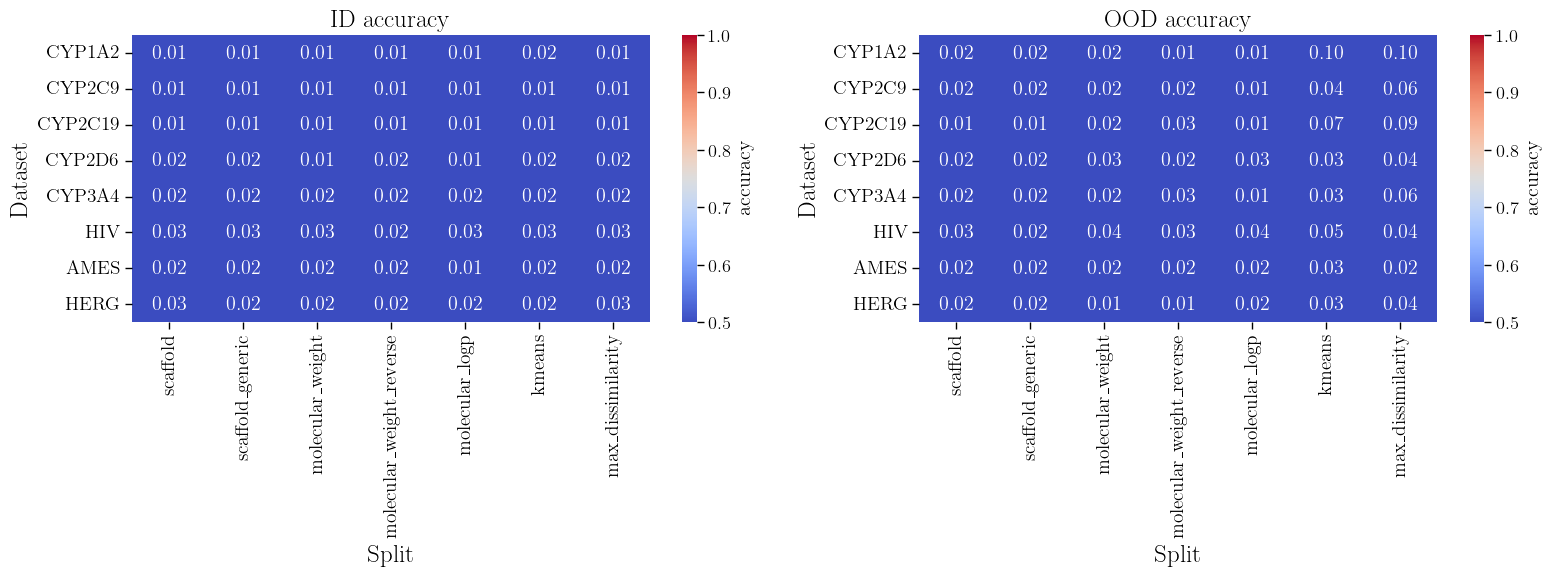

In [16]:
dataset_names = results["dataset"].unique()  # get the unique dataset names
metric = "accuracy"
save=False
# split_types = results["split"].unique()  # get the unique split types
# reorder the split types to this order
split_types = ["scaffold", "scaffold_generic", "molecular_weight", "molecular_weight_reverse", "molecular_logp", "kmeans", "max_dissimilarity"]
# create a dataframe to store the difference between ID and OOD for each dataset and split
id_df = pd.DataFrame(index=dataset_names, columns=split_types)
ood_df = pd.DataFrame(index=dataset_names, columns=split_types)


# fill the dataframe with the difference between ID and OOD for each dataset and split
for dataset in dataset_names:
    for split in split_types:
        id = results[(results["dataset"] == dataset) & (results["split"] == split)][f"ID_test_{metric}"].std()
        ood = results[(results["dataset"] == dataset) & (results["split"] == split)][f"OOD_test_{metric}"].std()
        id_df.loc[dataset, split] = id
        ood_df.loc[dataset, split] = ood

id_df = id_df.astype(float)
ood_df = ood_df.astype(float)

# plot the heatmap
vmin, vmax = 0.5, 1.0
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# one plot for id and one plot for ood
sns.heatmap(id_df, ax=ax[0], annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': f"{metric}"}, vmin=vmin, vmax=vmax)
ax[0].set_title(f"ID {metric}", fontsize=18)
ax[0].set_xlabel("Split", fontsize=18)
ax[0].set_ylabel("Dataset", fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=14)

sns.heatmap(ood_df, ax=ax[1], annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': f"{metric}"}, vmin=vmin, vmax=vmax)
ax[1].set_title(f"OOD {metric}", fontsize=18)
ax[1].set_xlabel("Split", fontsize=18)
ax[1].set_ylabel("Dataset", fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
if save:
    fig.savefig(
        os.path.join("assets", f"heatmap_id_ood_{metric}.pdf"),
        bbox_inches="tight",
        backend="pgf",
    )
plt.show()


# DEV

In [ ]:
from alinemol.utils import split_dataset, load_dataset
from dgllife.utils import CanonicalAtomFeaturizer
from dgllife.utils import CanonicalBondFeaturizer
dataset_category="TDC"
dataset_name="CYP2C19"
df = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset_name, f"{dataset_name}_standardize.csv"))
df = df[:2000]

In [ ]:
hopts = {"split": "random", "node_featurizer": CanonicalAtomFeaturizer(), "edge_featurizer": CanonicalBondFeaturizer(self_loop=True), "smiles_column":"smiles", "result_path":os.path.join(repo_path, 
    "classification_results", "TMP"), "num_workers":1, "task_names":"label", "split_ratio":"0.7,0.1,0.2"}
dataset = load_dataset(hopts, df)



In [ ]:
train_set, val_set, test_set = split_dataset(hopts, dataset)

In [ ]:
from dgl.data.utils import Subset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

In [ ]:
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

In [ ]:
num_data = len(dataset)
indices = list(sss.split(np.zeros(num_data), dataset.labels))[0][1]

In [ ]:
list(sss.split(np.zeros(num_data), dataset.labels))

In [ ]:
frac_list = [0.7, 0.1, 0.2]
random_state=123

In [ ]:
num_data = len(dataset)
split = StratifiedShuffleSplit(n_splits=1, test_size=frac_list[2], random_state=random_state)
for train_val_indices, test_indices in split.split(np.zeros(num_data), dataset.labels):
    train_val_indices = train_val_indices
    test_indices = test_indices

split = StratifiedShuffleSplit(n_splits=1, test_size=frac_list[1], random_state=random_state) 
num_data = len(train_val_indices)

for train_indices, val_indices in split.split(np.zeros(num_data), dataset.labels[train_val_indices]):
    train_indices = train_indices
    val_indices = val_indices

In [ ]:
print(train_indices)
print(val_indices)
print(test_indices)

In [ ]:
print(dataset.labels[train_val_indices].sum()/ len(train_val_indices))
print(dataset.labels[train_indices].sum()/ len(train_indices))
print(dataset.labels[val_indices].sum()/len(val_indices))
print(dataset.labels[test_indices].sum()/len(test_indices))
print(dataset.labels.sum()/len(dataset.labels))

In [ ]:
from dgl.data.utils import Subset
a=[Subset(dataset, train_indices), Subset(dataset, val_indices), Subset(dataset, test_indices)]

In [ ]:
import datamol as dm
smiles = df["smiles"]
labels = df["label"]
fps = np.array([dm.to_fp(dm.to_mol(smi)) for smi in smiles])

train_ratio, val_ratio, test_ratio = 0.7, 0.1, 0.2


In [ ]:
a=[train_indices, val_indices, test_indices] 

In [ ]:
b=[train_indices, val_indices, test_indices] 

In [ ]:
(a[2] == b[2]).all()

In [ ]:
## Find amount of overlap smiles between differet CYP datasets. Fix one CYP and find overlap with other cyps
CYPs = ["CYP1A2", "CYP2C19", "CYP2C9", "CYP3A4", "CYP2D6"]
dfs = []
for cyp in CYPs:
    df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", cyp, f"{cyp}_standardize.csv"))
    dfs.append(df)

print(len(dfs[0]))
overlap = set(dfs[0]["smiles"])
for df in dfs[1:]:
    overlap = overlap.intersection(set(df["smiles"]))
    print(len(overlap))



In [ ]:
### SVM BEST HYPERPARAMETER SEARCH
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from alinemol.utils.split_utils import sklearn_random_split, sklearn_stratified_random_split
import datamol as dm
df = pd.read_csv("datasets/TDC/CYP2C19/split/scaffold/train_0.csv")
smiles = df['smiles']
labels = df["label"]
fps = np.array([dm.to_fp(dm.to_mol(smi)) for smi in smiles])
train_ratio, val_ratio, test_ratio = 0.7, 0.1, 0.2
split_ratio = (train_ratio, val_ratio, test_ratio)

X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(fps, labels, split_ratio)

parameters_dictionary = {'kernel':['rbf'], 
                         'C':[1], 
                         'gamma':['scale', 'auto']}


svc = SVC()


grid_search = GridSearchCV(svc, 
                           parameters_dictionary, 
                           scoring = 'f1',
                           return_train_score=True, 
                           cv = 5,
                           verbose = 1) # Displays how many combinations of parameters and folds we'll have, for more information as the time to run each search, use 2 or 3 values instead of 1)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_) 
print(grid_search.best_estimator_) 
print(grid_search.best_score_)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
grid_predictions = grid_search.predict(X_test) 
# print classification report 
print(classification_report(y_test, grid_predictions)) 

# Visualize Chemical Sapce

In [ ]:
dataset_names = ["CYP1A2", "CYP2C19", "CYP2C9", "CYP2D6", "CYP3A4", "HIV", "AMES", "HERG"] 
dfs = []
for dataset in dataset_names:
    df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
    dfs.append(df)

# concat them and just keep the smiles column and then drop duplicates
smiles = pd.concat([df["smiles"] for df in dfs])
smiles = smiles.drop_duplicates()
print(f"Number of unique smiles: {smiles.shape[0]}")

In [ ]:
# Find out how many molecules/smiles are shared between the datasets
shared = []
for df1 in dfs:
    for df2 in dfs:
        shared.append(df1["smiles"].isin(df2["smiles"]).sum())
shared = np.array(shared).reshape(len(dataset_names), len(dataset_names))
shared_df = pd.DataFrame(shared, index=dataset_names, columns=dataset_names)
shared_df.to_latex(buf="assets/shared.tex", float_format="%.2f", index=True, escape=False)
    

In [ ]:
# check smiles available in which datasets. create dataframe with number of smiles in a row and dataset names in columns.
# if smiles is available in the dataset, put 1, otherwise 0
dff = pd.DataFrame(index=np.arange(len(smiles)), columns=dataset_names)
dff["smiles"] = smiles.values
for dataset, df in zip(dataset_names, dfs):
    dff[dataset] = dff['smiles'].apply(lambda x: 1 if x in df['smiles'].values else 0)

In [ ]:
for dataset, df in zip(dataset_names, dfs):
    # return thr corresponding label for the smiles
    dff[f"{dataset}_label"] = dff['smiles'].apply(lambda x: 2 * df[df['smiles'] == x]['label'].values[0] - 1 if x in df['smiles'].values else 0)

In [ ]:
dff

In [ ]:
X, metric = convert_to_default_feats_if_smiles(smiles, "jaccard", 8)

In [ ]:
transformer = EmpiricalKernelMapTransformer(
    n_samples=min(512, len(X)),
    metric=metric,
    random_state=1234,
)
X = transformer(np.array(X))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
# Dimensionality reduction functions
def reduce_dimensionality(data, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'umap':
        reducer = umap.UMAP(random_state=42)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'.")
    return reducer.fit_transform(data)


In [ ]:
# Reduce dimensionality
pca_data = reduce_dimensionality(X, method='pca')
tsne_data = reduce_dimensionality(X, method='tsne')
umap_data = reduce_dimensionality(X, method='umap')

In [ ]:
# Plotting function
def plot_2d(data, title, save=False):
    fig, ax = plt.subplots(4, 2,  figsize=(20, 16))
    ax = ax.flatten()
    for i, dataset in enumerate(dataset_names):
        highlight_indices = dff[dataset].values == 1
        sns.scatterplot(x=data[:, 0], y=data[:, 1], color="gray", alpha=0.5, s=5, ax=ax[i], label="Whole datasets")
        sns.scatterplot(
            x=data[highlight_indices, 0],
            y=data[highlight_indices, 1],
            #hue=highlight_indices,
            palette="Set2",
            ax=ax[i],
            #label=dataset,
            edgecolor='blue',
            color='blue',
            linewidth=0.5,
            s=2
        )
        ax[i].set_title(f"{dataset}")
        ax[i].legend()
    
    # add title to the whole plot
    fig.suptitle(f"{title} Plot of Chemical Space", fontsize=20)
    
    plt.tight_layout()
    if save:
        # save the plot to png
        plt.savefig(f"assets/{title}_chemicalspace_plot.png", bbox_inches="tight")
        # save the plot to pdf
        plt.savefig(f"assets/{title}_chemicalspace_plot.pdf")

    plt.show()

In [ ]:
# Plotting function
def plot_2d_with_labels(data, title, save=False):
    fig, ax = plt.subplots(4, 2,  figsize=(20, 16))
    ax = ax.flatten()
    for i, dataset in enumerate(dataset_names):
        highlight_indices_active = dff[f"{dataset}_label"].values == 1
        highlight_indices_inactive = dff[f"{dataset}_label"].values == -1
        sns.scatterplot(x=data[:, 0], y=data[:, 1], color="gray", alpha=0.5, s=5, ax=ax[i], label="Whole datasets")
        sns.scatterplot(
            x=data[highlight_indices_active, 0],
            y=data[highlight_indices_active, 1],
            #hue=highlight_indices,
            palette="Set2",
            ax=ax[i],
            label="Active",
            edgecolor='tab:green',
            color='tab:green',
            linewidth=0.5,
            s=5,
            alpha=1.0
        )

        sns.scatterplot(
            x=data[highlight_indices_inactive, 0],
            y=data[highlight_indices_inactive, 1],
            #hue=highlight_indices,
            palette="Set2",
            ax=ax[i],
            label="Inactive",
            edgecolor='tab:orange',
            color='tab:orange',
            linewidth=0.5,
            s=5,
            alpha=0.4
        )
        
        ax[i].set_title(f"{dataset}")
        ax[i].legend()
    
    
    # add title to the whole plot
    fig.suptitle(f"{title} Plot of Chemical Space with Highlighted Active and Inactive", fontsize=20)
    
    plt.tight_layout()
    if save:
        # save the plot to png
        plt.savefig(f"assets/{title}_chemicalspace_label_plot.png", bbox_inches="tight")
        # save the plot to pdf
        plt.savefig(f"assets/{title}_chemicalspace_label_plot.pdf")

    plt.show()

In [ ]:
plot_2d_with_labels(tsne_data, "TSNE", True)

# K- Nearest Dataset Distance

In [ ]:
from alinemol.utils.split_utils import retrieve_k_nearest_neighbors, train_test_dataset_distance_retrieve, sklearn_stratified_random_split

id_df = pd.read_csv("datasets/TDC/CYP2C19/split/scaffold/train_0.csv")
X, y = np.array(id_df["smiles"]), np.array(id_df["label"])
X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(X, y, (0.72, 0.08, 0.2))
train_df = pd.DataFrame({"smiles": X_train, "label": y_train})

In [4]:
from alinemol.utils.split_utils import retrieve_k_nearest_neighbors, train_test_dataset_distance_retrieve, sklearn_stratified_random_split
from tqdm import tqdm

cfg = yaml.safe_load(open(os.path.join("datasets", "config.yml"), "r"))
datasets = cfg["datasets"]["TDC"]
splitting = cfg["splitting"]
#splitting = ["scaffold"]
index = np.arange(10)

df_list = []
for split in tqdm(splitting):
    for dataset in datasets:
        original_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
        pairwise_distance = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"Jaccard_distance.npy"))
        for idx in index: 
            id_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"train_{idx}.csv"))
            X, y = np.array(id_df["smiles"]), np.array(id_df["label"])
            X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(X, y, (0.72, 0.08, 0.2))
            train_df = pd.DataFrame({"smiles": X_train, "label": y_train})
            test_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"test_{idx}.csv"))
            sim_vals = retrieve_k_nearest_neighbors(pairwise_distance, original_df, train_df, test_df, k=5)
            sim_df = pd.DataFrame({"similarity": sim_vals, "split": split, "dataset": dataset, "index": idx})
            df_list.append(sim_df)

sim_df = pd.concat(df_list)


100%|██████████| 7/7 [02:23<00:00, 20.43s/it]


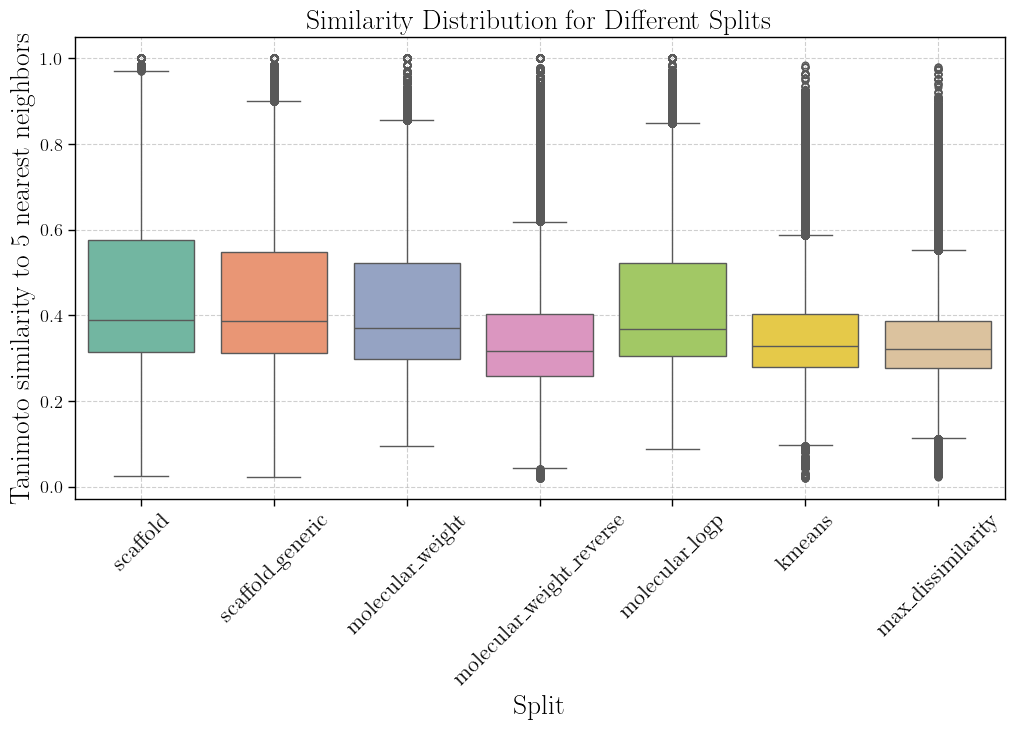

In [5]:
# Just groupby based on slpitting. Then plot the box plot for similarity values
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(x="split", y="similarity", data=sim_df, hue="split", ax=ax)
plt.xlabel("Split", fontsize=20)
plt.ylabel("Tanimoto similarity to 5 nearest neighbors", fontsize=20)
plt.title("Similarity Distribution for Different Splits", fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.6)
# rotate the xticks
plt.xticks(rotation=45, fontsize=16)

# save to pdf
plt.savefig("assets/similarity_distribution_jaccard.pdf", bbox_inches="tight")
# save to png
plt.savefig("assets/similarity_distribution_jaccard.png", bbox_inches="tight")
plt.show()

In [6]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform the tukey test
tukey_res = pairwise_tukeyhsd(sim_df.similarity, sim_df.split)

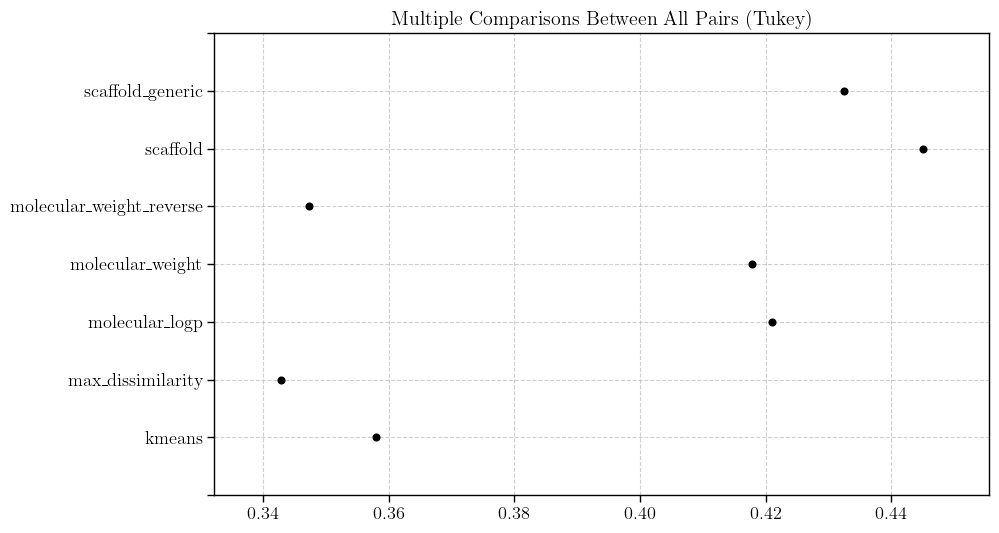

In [7]:
_ = tukey_res.plot_simultaneous()
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.show()


In [15]:
print(tukey_res)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                   group2          meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------------------------
                  kmeans        max_dissimilarity   -0.015   0.0 -0.0158 -0.0143   True
                  kmeans           molecular_logp    0.063   0.0  0.0624  0.0637   True
                  kmeans         molecular_weight   0.0598   0.0  0.0592  0.0605   True
                  kmeans molecular_weight_reverse  -0.0107   0.0 -0.0114   -0.01   True
                  kmeans                 scaffold    0.087   0.0  0.0864  0.0877   True
                  kmeans         scaffold_generic   0.0746   0.0  0.0739  0.0753   True
       max_dissimilarity           molecular_logp   0.0781   0.0  0.0773  0.0788   True
       max_dissimilarity         molecular_weight   0.0749   0.0  0.0741  0.0756   True
       max_dissimilarity molecul

In [30]:
split = "max_dissimilarity"
dataset = "HERG"
idx = 0
train_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"train_{idx}.csv"))
test_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"test_{idx}.csv"))
original_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
pairwise_distance = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"Jaccard_distance.npy"))
a=train_test_dataset_distance_retrieve(original_df, train_df, test_df, pairwise_distance)


In [31]:
print(a.shape)
print(original_df.shape)
print(train_df.shape)
print(test_df.shape)


(10370, 2520)
(12890, 2)
(10370, 2)
(2520, 2)


In [ ]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))
metric = "roc_auc"
# box plot the differenbce between ID and OOD for all the splits
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df = results.copy()
df["difference"] = df[f"ID_test_{metric}"] - df[f"OOD_test_{metric}"]
sns.boxplot(x="split", y="difference", data=df, hue="split", ax=ax)
plt.xlabel("Split", fontsize=20)
plt.ylabel("Difference in ROC AUC", fontsize=20)
plt.title("Difference in ROC AUC for Different Splits", fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.6)
# rotate the xticks
plt.xticks(rotation=45)

plt.show()

In [ ]:
tukey_res = pairwise_tukeyhsd(df.difference, df.split)
print(tukey_res)
_ = tukey_res.plot_simultaneous()
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.show()

In [16]:
## retrieve TMD for all the datasets and splits

from alinemol.utils.split_utils import train_test_dataset_distance_retrieve, sklearn_stratified_random_split, retrieve_k_nearest_neighbors_TMD
from tqdm import tqdm

cfg = yaml.safe_load(open(os.path.join("datasets", "config.yml"), "r"))
datasets = datasets = cfg["datasets"]["TDC"]
splitting = cfg["splitting"]
#splitting = ["scaffold"]
index = np.arange(10)
df_list = []
for split in tqdm(splitting):
    for dataset in datasets:
        original_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
        pairwise_distance = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"TMD_distance.npy"))
        for idx in index: 
            id_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"train_{idx}.csv"))
            X, y = np.array(id_df["smiles"]), np.array(id_df["label"])
            X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(X, y, (0.72, 0.08, 0.2))
            train_df = pd.DataFrame({"smiles": X_train, "label": y_train})
            test_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"test_{idx}.csv"))
            sim_vals = retrieve_k_nearest_neighbors_TMD(pairwise_distance, original_df, train_df, test_df, k=5)
            sim_df = pd.DataFrame({"similarity": sim_vals, "split": split, "dataset": dataset, "index": idx})
            df_list.append(sim_df)

sim_df = pd.concat(df_list)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [02:21<00:00, 20.23s/it]


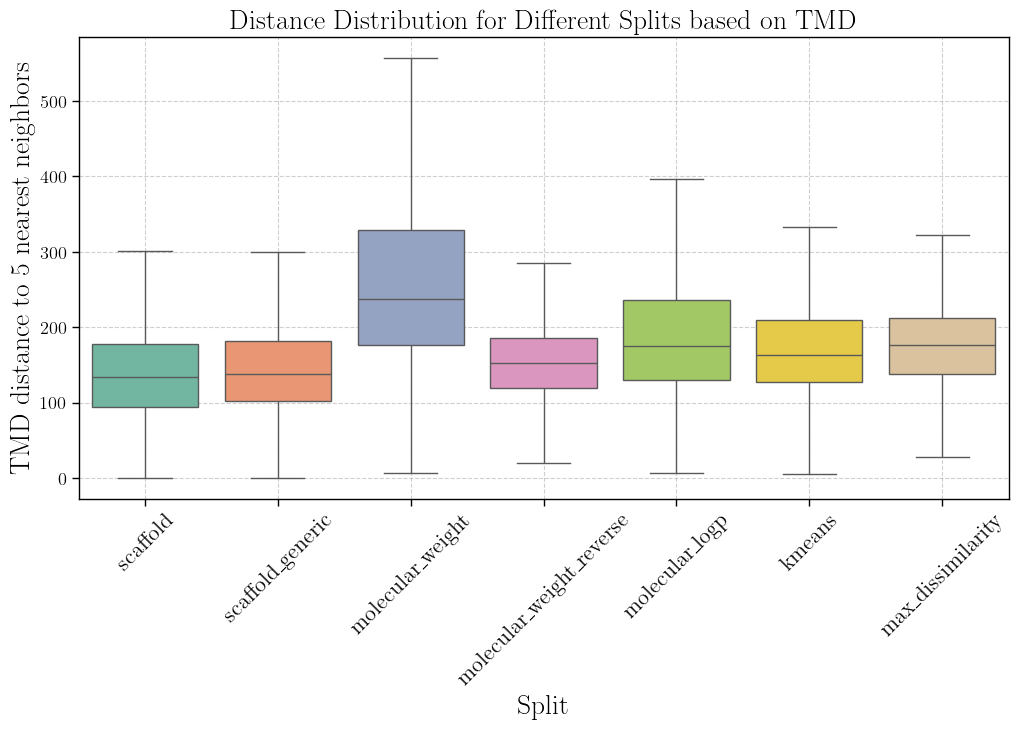

In [17]:
# Just groupby based on slpitting. Then plot the box plot for similarity values
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(x="split", y="similarity", data=sim_df, hue="split", ax=ax, showfliers=False)
plt.xlabel("Split", fontsize=20)
plt.ylabel("TMD distance to 5 nearest neighbors", fontsize=20)
plt.title("Distance Distribution for Different Splits based on TMD", fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.6)
# rotate the xticks
plt.xticks(rotation=45, fontsize=16)

# save to pdf
#plt.savefig("assets/similarity_distribution_jaccard.pdf", bbox_inches="tight")
# save to png
#plt.savefig("assets/similarity_distribution_jaccard.png", bbox_inches="tight")
plt.show()

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform the tukey test
tukey_res = pairwise_tukeyhsd(sim_df.similarity, sim_df.split)

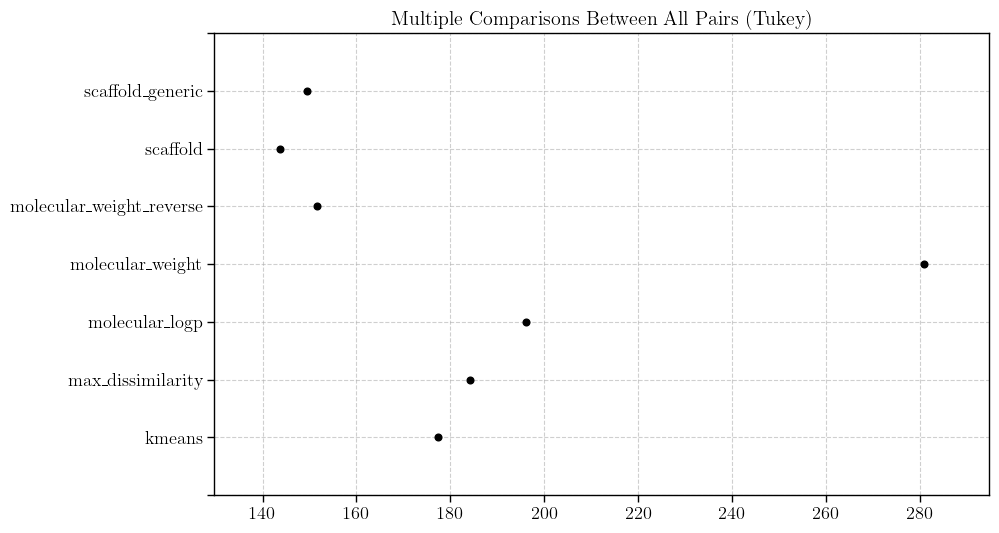

In [19]:
_ = tukey_res.plot_simultaneous()
plt.grid(axis='both', linestyle='--', alpha=0.6)
plt.show()

# Hyperparameter Optimization


In [ ]:
from alinemol.utils.split_utils import sklearn_random_split, sklearn_stratified_random_split
df = pd.read_csv("datasets/TDC/CYP2C19/split/scaffold/train_0.csv")
smiles = df['smiles']
labels = np.array(df["label"])
fps = np.array([dm.to_fp(dm.to_mol(smi)) for smi in smiles])
split_ratio = 0.72, 0.08, 0.2
train_ratio, val_ratio, test_ratio = split_ratio
assert train_ratio + val_ratio + test_ratio == 1
split_ratio = (train_ratio, val_ratio, test_ratio)

X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(fps, labels, split_ratio)


In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [ ]:
y_train.sum()/len(y_train), y_val.sum()/len(y_val), y_test.sum()/len(y_test)

In [ ]:
df = pd.read_csv("datasets/TDC/HIV/split/scaffold/train_0.csv")

from alinemol.utils.split_utils import sklearn_random_split, sklearn_stratified_random_split
from sklearn.tree import DecisionTreeClassifier
#  import random forest classifier
from sklearn.ensemble import RandomForestClassifier
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import SVC
from sklearn.svm import SVC

# import xgboost
from xgboost import XGBClassifier

# import LIGHGBM classifier
from lightgbm import LGBMClassifier

smiles = df['smiles']
labels = np.array(df["label"])
fps = np.array([dm.to_fp(dm.to_mol(smi)) for smi in smiles])
train_ratio, val_ratio, test_ratio = 0.72, 0.08, 0.2
assert train_ratio + val_ratio + test_ratio == 1
split_ratio = (train_ratio, val_ratio, test_ratio)
X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(fps, labels, split_ratio)


#Define hyperparameters for Random Forest

rf_params = {
    'n_estimators': [100, 200, 300, 400], #https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
    'criterion': ['gini'],
    'max_depth': [5, 10, 20, 40],
    'min_samples_split': [2, 4, 8, 16],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

svm_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, "scale", "auto"],
    'kernel': ['rbf']
}

xgboost_params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0, 1.0],
    'reg_lambda': [0, 1.0],
    "objective": ["binary:logistic"],
    'min_child_weight': [1, 3]
}

lightgbm_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [7, 31],
    'min_child_samples': [1, 5],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [1.0],
    'reg_lambda': [1.0]
}

dt_grid_search = GridSearchCV(estimator=LGBMClassifier(random_state=None),
                              param_grid=lightgbm_params, cv=5, n_jobs=128, verbose=1, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Info] Number of positive: 605, number of negative: 1588
[LightGBM] [Info] Number of positive: 604, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 604, number of negative: 1589
[LightGBM] [Info] Number of positive: 604, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 604, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of negative: 1589
[LightGBM] [Info] Number of positive: 605, number of

In [ ]:
print(dt_grid_search.best_params_)
print(dt_grid_search.best_score_)
print(dt_grid_search.best_estimator_)


In [ ]:
dt_grid_search.scoring

In [ ]:
results = dt_grid_search.cv_results_

In [ ]:
results['split1_test_score']

In [ ]:
# import SVC
from sklearn.svm import SVC
svm_params = {"C": [0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100], "kernel": ["rbf"]}

In [ ]:
from alinemol.utils.metric_utils import eval_acc, eval_roc_auc, eval_pr_auc

num_of_splits=4
RESULTS_PATH = "TMP/TDC/CYP1A2/scaffold"
ID_test_accuracy = []
OOD_test_accuracy = []

ID_test_roc_auc = []
OOD_test_roc_auc = []

ID_test_pr_auc = []
OOD_test_pr_auc = []

test_size = []
filenames = [f"test_{i}.csv" for i in range(0, num_of_splits)]
model_names = ["randomForest"]
for i in range(0, num_of_splits):
    for model_name in model_names:
        df = pd.read_csv(os.path.join(RESULTS_PATH, model_name, str(i + 1), "eval.txt"), sep=":", header=None)
        ID_test_accuracy.append(df.iloc[1, 1])
        ID_test_roc_auc.append(df.iloc[2, 1])
        ID_test_pr_auc.append(df.iloc[3, 1])

for i, filename in enumerate(filenames):
    df1 = pd.read_csv(os.path.join(RESULTS_PATH, filename))
    print(df1.shape)
    for model_name in model_names:
        df = pd.read_csv(os.path.join(RESULTS_PATH, model_name, str(i + 1), "prediction.csv"))
        print(df.shape)
        OOD_test_accuracy.append(eval_acc(df1, df))
        OOD_test_roc_auc.append(eval_roc_auc(df1, df))
        OOD_test_pr_auc.append(eval_pr_auc(df1, df))
        test_size.append(df1.shape[0])

result_df = pd.DataFrame(
    {
        "ID_test_accuracy": ID_test_accuracy,
        "OOD_test_accuracy": OOD_test_accuracy,
        "ID_test_roc_auc": ID_test_roc_auc,
        "OOD_test_roc_auc": OOD_test_roc_auc,
        "ID_test_pr_auc": ID_test_pr_auc,
        "OOD_test_pr_auc": OOD_test_pr_auc,
    }
)

result_df["model"] = [model_name for i in range(0, num_of_splits) for model_name in model_names]
result_df["test_size"] = test_size
result_df["split"] = split_type


In [ ]:
result_df

In [44]:
df_cyp2c19 = pd.read_csv("datasets/TDC/CYP2C19/CYP2C19_standardize.csv")
df_cyp1A2 = pd.read_csv("datasets/TDC/CYP1A2/CYP1A2_standardize.csv")

## find the smiles and index of that smiles that are in CYP1A2 and not in CYP2C19

smiles_cyp2c19 = set(df_cyp2c19["smiles"])
smiles_cyp1A2 = set(df_cyp1A2["smiles"])

smiles_cyp1A2_not_cyp2c19 = smiles_cyp1A2.difference(smiles_cyp2c19)

# find the index of the smiles in CYP1A2 that are not in CYP2C19
idx = df_cyp1A2[df_cyp1A2["smiles"].isin(smiles_cyp1A2_not_cyp2c19)].index

# create dataframe with the index and smiles
df_cyp1A2_not_cyp2c19 = df_cyp1A2.loc[idx, ["smiles"]]
df_cyp1A2_not_cyp2c19


,smiles
1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...
2,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21
7,COc1ccc(C(=O)C2C(=O)C(=O)N(CCCC(=O)O)C2c2ccc(O...
9,CCN(CC)C(=O)CSc1nnc(-c2cc3ccccc3cc2O)n1CC
16,Cc1ccc2cc(C)c3nnc(SCC(=O)NCc4ccco4)n3c2c1
...,...
12448,CC(C)CO/N=C1/C[C@@H](O)[C@@H](O)[C@@H]2c3c(c(O...
12503,C#CCCCO/N=C1/[C@H]2O[C@@H]2[C@@H](O)[C@H]2[C@H...
12509,O=C1C2=CCc3c(c(O)n(C[C@@H]4CCCO4)c3O)[C@@H]2[C...
12525,C[C@@H](c1ccccc1)n1c(O)c2c(c1O)[C@@H]1[C@H](O)...
